In [48]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
import json
import ast
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import warnings
import IPython.display as ipd

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Configure visualization settings
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.2)
warnings.filterwarnings('ignore')

# Directory paths - adjust as needed
BASE_DIR = './'  # Local path for the dataset (adjust as needed)
TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, 'train_audio')  # Folder with training audio files
TEST_AUDIO_DIR = os.path.join(BASE_DIR, 'test_audio')  # Folder with test audio files

# Constants
SAMPLE_RATE = 22050  # Set to 22.05 kHz to match the common practice in audio processing
N_CLASSES = 206  # Total number of species classes (can be adjusted based on your dataset)
AUDIO_EXT = '.ogg'  # Audio file extension ('.ogg' or '.wav', etc.)

# Print out directories and configuration for validation
print(f"Base Directory: {BASE_DIR}")
print(f"Training Audio Directory: {TRAIN_AUDIO_DIR}")
print(f"Test Audio Directory: {TEST_AUDIO_DIR}")
print(f"Sample Rate: {SAMPLE_RATE}")
print(f"Number of Classes: {N_CLASSES}")


Base Directory: ./
Training Audio Directory: ./train_audio
Test Audio Directory: ./test_audio
Sample Rate: 22050
Number of Classes: 206


In [50]:
import pandas as pd
import os

# Load metadata
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
taxonomy_df = pd.read_csv(os.path.join(BASE_DIR, 'taxonomy.csv'))
sample_submission = pd.read_csv(os.path.join(BASE_DIR, 'sample_submission.csv'))

# Display the shapes of the datasets
print(f"Train data shape: {train_df.shape}")
print(f"Taxonomy data shape: {taxonomy_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

### 2.1 Basic Statistics & Data Types

# Display column info for each dataset
print("\nTrain columns:", train_df.columns.tolist())
print("Taxonomy columns:", taxonomy_df.columns.tolist())
print("Sample submission columns:", sample_submission.columns.tolist())

# Check data types for each dataset
print("\nTrain data types:")
print(train_df.dtypes)

print("\nTaxonomy data types:")
print(taxonomy_df.dtypes)

# Basic statistics for the 'train' data (this will give summary statistics for numerical and categorical columns)
print("\nTrain data description:")
print(train_df.describe(include='all').T)

# Check for missing values in each dataset
print("\nMissing values in train data:")
print(train_df.isnull().sum())

print("\nMissing values in taxonomy data:")
print(taxonomy_df.isnull().sum())

# Get a sample of rows from the 'train' and 'taxonomy' data
print("\nSample rows from train data:")
print(train_df.sample(5))

print("\nSample rows from taxonomy data:")
print(taxonomy_df.sample(5))


Train data shape: (28564, 13)
Taxonomy data shape: (206, 5)
Sample submission shape: (3, 207)

Train columns: ['primary_label', 'secondary_labels', 'type', 'filename', 'collection', 'rating', 'url', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license']
Taxonomy columns: ['primary_label', 'inat_taxon_id', 'scientific_name', 'common_name', 'class_name']
Sample submission columns: ['row_id', '1139490', '1192948', '1194042', '126247', '1346504', '134933', '135045', '1462711', '1462737', '1564122', '21038', '21116', '21211', '22333', '22973', '22976', '24272', '24292', '24322', '41663', '41778', '41970', '42007', '42087', '42113', '46010', '47067', '476537', '476538', '48124', '50186', '517119', '523060', '528041', '52884', '548639', '555086', '555142', '566513', '64862', '65336', '65344', '65349', '65373', '65419', '65448', '65547', '65962', '66016', '66531', '66578', '66893', '67082', '67252', '714022', '715170', '787625', '81930', '868458', '963335', 'amakin1', 

Number of unique primary labels: 206


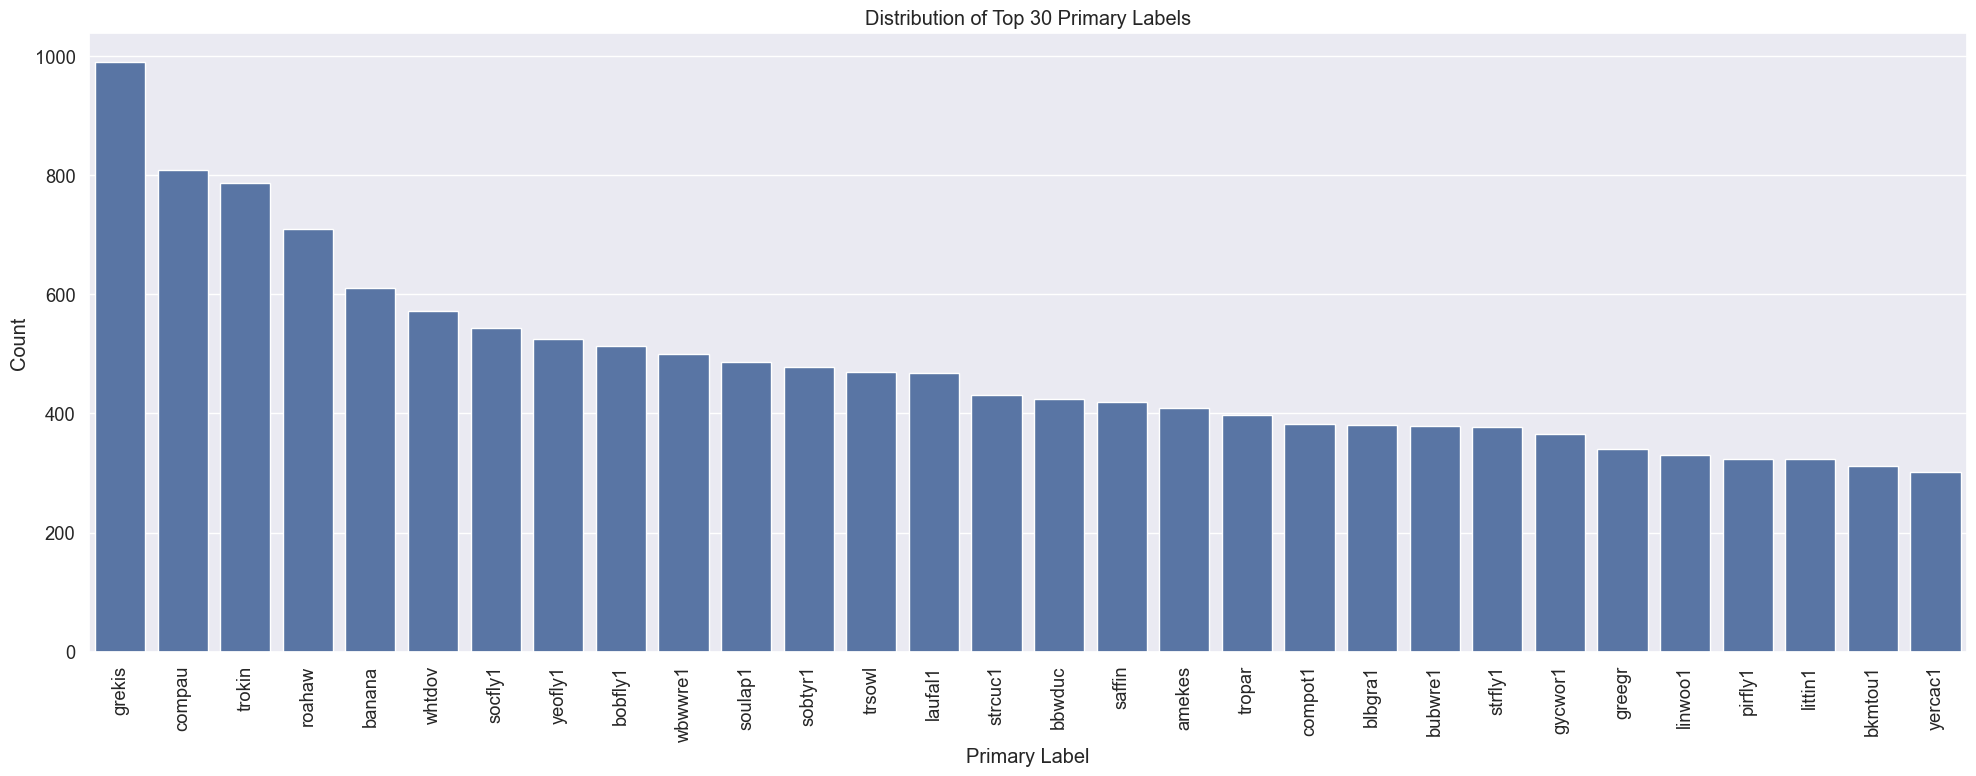

Most common species: grekis with 990 samples
Least common species: 1139490 with 2 samples
Imbalance ratio (most common / least common): 495.00


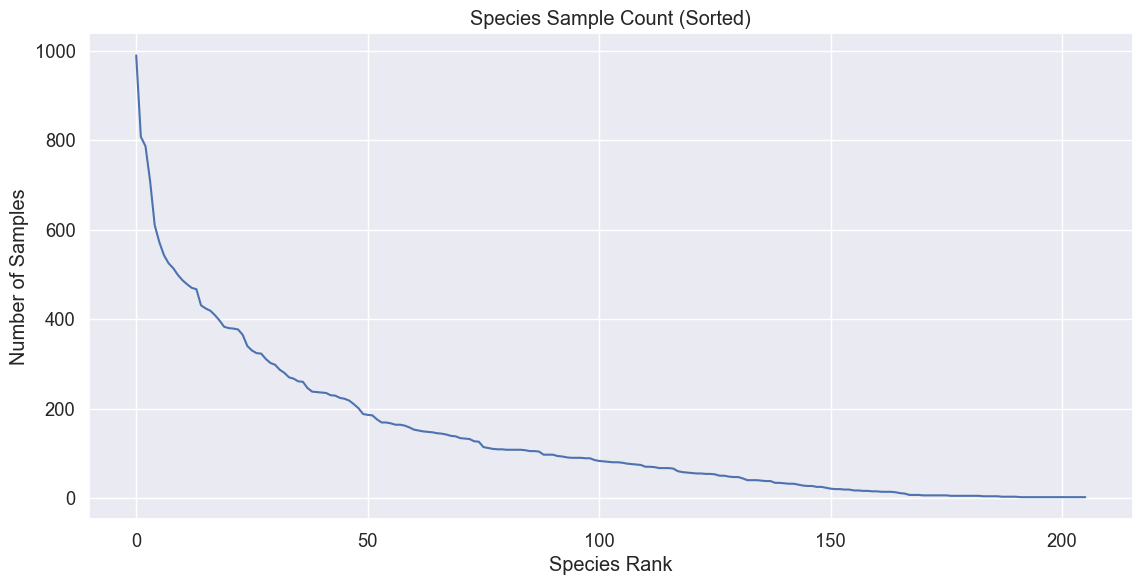

Number of rare classes (<10 samples): 39
Rare classes: {'65547': 7, '787625': 7, '1462737': 7, 'plctan1': 6, '555142': 6, '126247': 6, '65336': 6, '1564122': 6, '24272': 6, '548639': 5, '46010': 5, '1346504': 5, '963335': 5, '476538': 5, '714022': 5, '66893': 5, '134933': 4, '1192948': 4, '868458': 4, '523060': 4, '24292': 3, '65419': 3, '1194042': 3, '1462711': 3, '81930': 2, '67082': 2, '66578': 2, '66531': 2, '66016': 2, '21038': 2, '41778': 2, '21116': 2, '64862': 2, '528041': 2, '476537': 2, '47067': 2, '42113': 2, '42087': 2, '1139490': 2}


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count primary labels
primary_label_counts = train_df['primary_label'].value_counts()
print(f"Number of unique primary labels: {len(primary_label_counts)}")

# Plot distribution of the top 30 primary labels
plt.figure(figsize=(20, 8))
ax = sns.barplot(x=primary_label_counts.index[:30], y=primary_label_counts.values[:30])
plt.title('Distribution of Top 30 Primary Labels')
plt.xticks(rotation=90)
plt.xlabel('Primary Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Show statistics about class imbalance
print(f"Most common species: {primary_label_counts.index[0]} with {primary_label_counts.values[0]} samples")
print(f"Least common species: {primary_label_counts.index[-1]} with {primary_label_counts.values[-1]} samples")
print(f"Imbalance ratio (most common / least common): {primary_label_counts.values[0] / primary_label_counts.values[-1]:.2f}")

# Analyze the long tail
plt.figure(figsize=(12, 6))
plt.plot(range(len(primary_label_counts)), sorted(primary_label_counts.values, reverse=True))
plt.title('Species Sample Count (Sorted)')
plt.xlabel('Species Rank')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

# Determine rare classes (< 10 samples)
rare_classes = primary_label_counts[primary_label_counts < 10]
print(f"Number of rare classes (<10 samples): {len(rare_classes)}")
print(f"Rare classes: {rare_classes.to_dict()}")


First few secondary_labels:
1: ['']
2: ['']
3: ['']
4: ['']
5: ['']

Recordings with secondary labels: 28539 (99.91%)


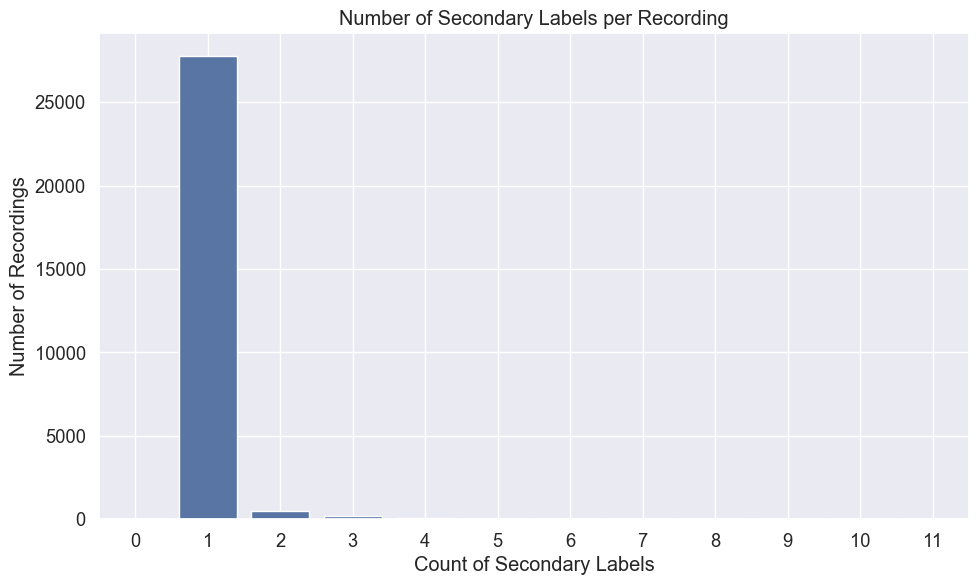


Top 10 most common secondary labels:
: 25885
grekis: 489
whtdov: 309
trokin: 188
soulap1: 114
pirfly1: 112
rugdov: 110
banana: 104
saffin: 102
yebela1: 96

Average number of labels per recording: 2.04
Maximum number of labels in a recording: 12


In [54]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Check the format of secondary_labels
print("First few secondary_labels:")
for i in range(5):
    print(f"{i+1}: {train_df['secondary_labels'].iloc[i]}")

# Parse secondary_labels (assuming they're in string representation of list format)
def parse_secondary_labels(label_str):
    if pd.isna(label_str):
        return []
    try:
        return ast.literal_eval(label_str)  # Convert string representation of list to actual list
    except:
        return []  # Return empty list if parsing fails

train_df['parsed_secondary_labels'] = train_df['secondary_labels'].apply(parse_secondary_labels)

# Count how many recordings have secondary labels
has_secondary = train_df['parsed_secondary_labels'].apply(lambda x: len(x) > 0)
print(f"\nRecordings with secondary labels: {has_secondary.sum()} ({has_secondary.sum()/len(train_df)*100:.2f}%)")

# Get distribution of the number of secondary labels per recording
secondary_counts = train_df['parsed_secondary_labels'].apply(len)
plt.figure(figsize=(10, 6))
sns.countplot(x=secondary_counts)
plt.title('Number of Secondary Labels per Recording')
plt.xlabel('Count of Secondary Labels')
plt.ylabel('Number of Recordings')
plt.grid(True)
plt.show()

# Most common secondary labels
all_secondary = []
for labels in train_df['parsed_secondary_labels']:
    all_secondary.extend(labels)  # Flatten the list of secondary labels

secondary_counter = Counter(all_secondary)  # Count occurrences of each label
print("\nTop 10 most common secondary labels:")
for label, count in secondary_counter.most_common(10):
    print(f"{label}: {count}")

# Create multi-label representation (primary + secondary labels)
def create_multilabel_vector(row):
    # Initialize with primary label
    labels = [row['primary_label']]
    # Add secondary labels if they exist
    if not pd.isna(row['secondary_labels']):
        try:
            secondary = ast.literal_eval(row['secondary_labels'])
            if isinstance(secondary, list):
                labels.extend(secondary)
        except:
            pass
    return labels

train_df['all_labels'] = train_df.apply(create_multilabel_vector, axis=1)

# Count total labels per recording (primary + secondary)
train_df['total_label_count'] = train_df['all_labels'].apply(len)
print(f"\nAverage number of labels per recording: {train_df['total_label_count'].mean():.2f}")
print(f"Maximum number of labels in a recording: {train_df['total_label_count'].max()}")


Distribution of classes:
class_name
Aves        146
Amphibia     34
Insecta      17
Mammalia      9
Name: count, dtype: int64


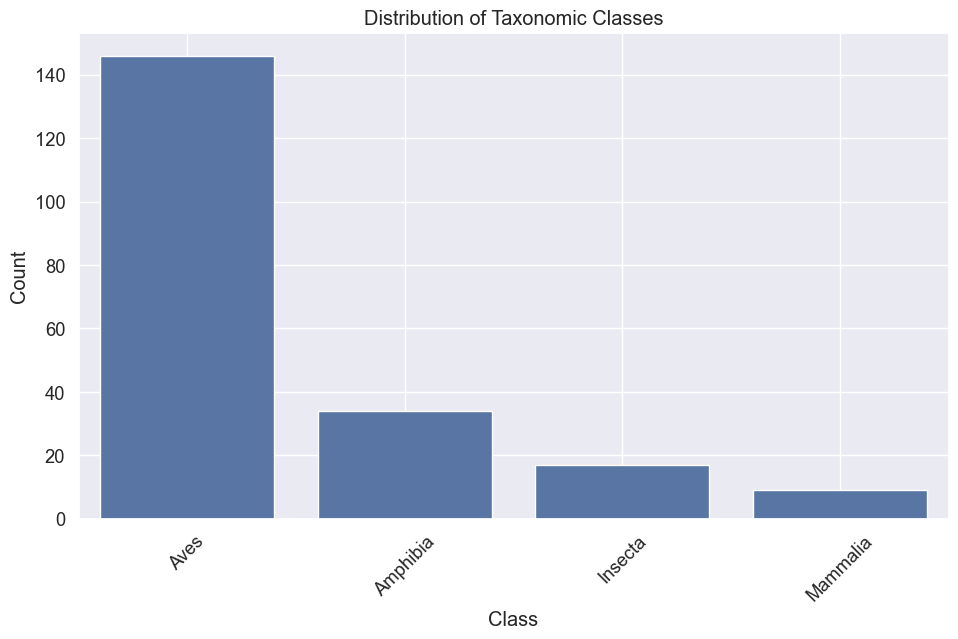

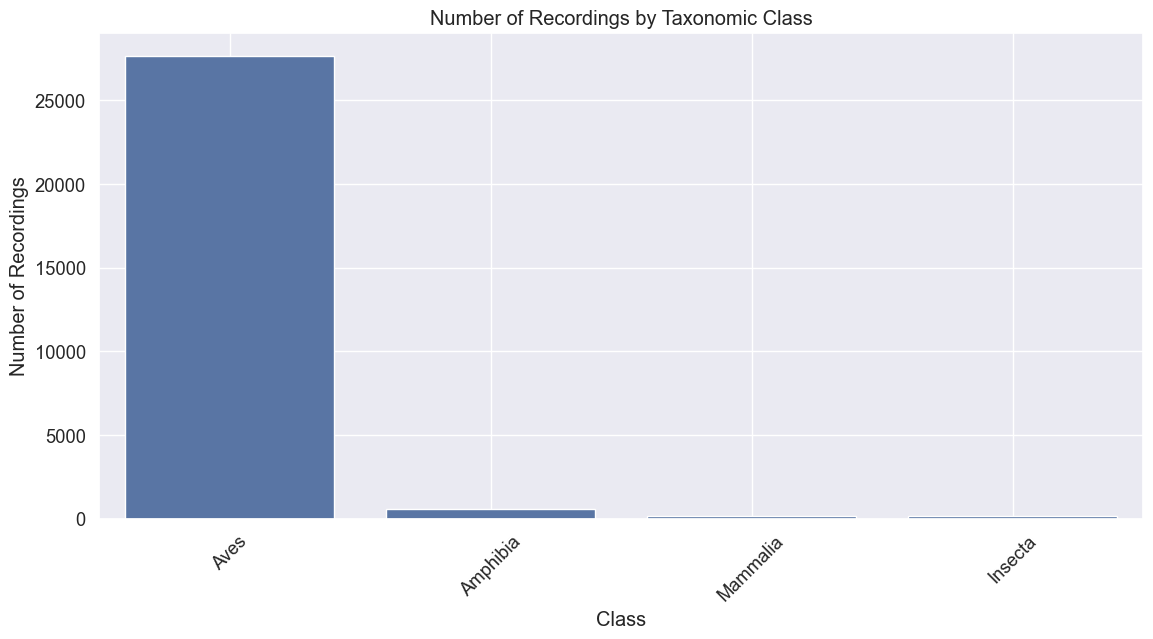

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze class_name distribution in taxonomy
class_counts = taxonomy_df['class_name'].value_counts()
print("Distribution of classes:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Taxonomic Classes')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Merge train data with taxonomy for further analysis
train_with_taxonomy = pd.merge(train_df, taxonomy_df, on='primary_label', how='left')

# Check for any missing matches
missing_taxonomy = train_with_taxonomy[train_with_taxonomy['class_name'].isna()]
if len(missing_taxonomy) > 0:
    print(f"Warning: {len(missing_taxonomy)} training samples don't have matching taxonomy entries")
    print(missing_taxonomy['primary_label'].unique())

# Analyze recordings by taxonomic class
class_recording_counts = train_with_taxonomy['class_name'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=class_recording_counts.index, y=class_recording_counts.values)
plt.title('Number of Recordings by Taxonomic Class')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Number of Recordings')
plt.grid(True)
plt.show()

# Check for discrepancies between train and taxonomy scientific names
scientific_name_match = train_with_taxonomy['scientific_name_x'] == train_with_taxonomy['scientific_name_y']
if not scientific_name_match.all():
    print(f"Warning: {(~scientific_name_match).sum()} records have mismatched scientific names")
    mismatched = train_with_taxonomy[~scientific_name_match][['primary_label', 'scientific_name_x', 'scientific_name_y']]
    print(mismatched.sample(min(5, len(mismatched))))


Recordings with location data: 27755 (97.17%)


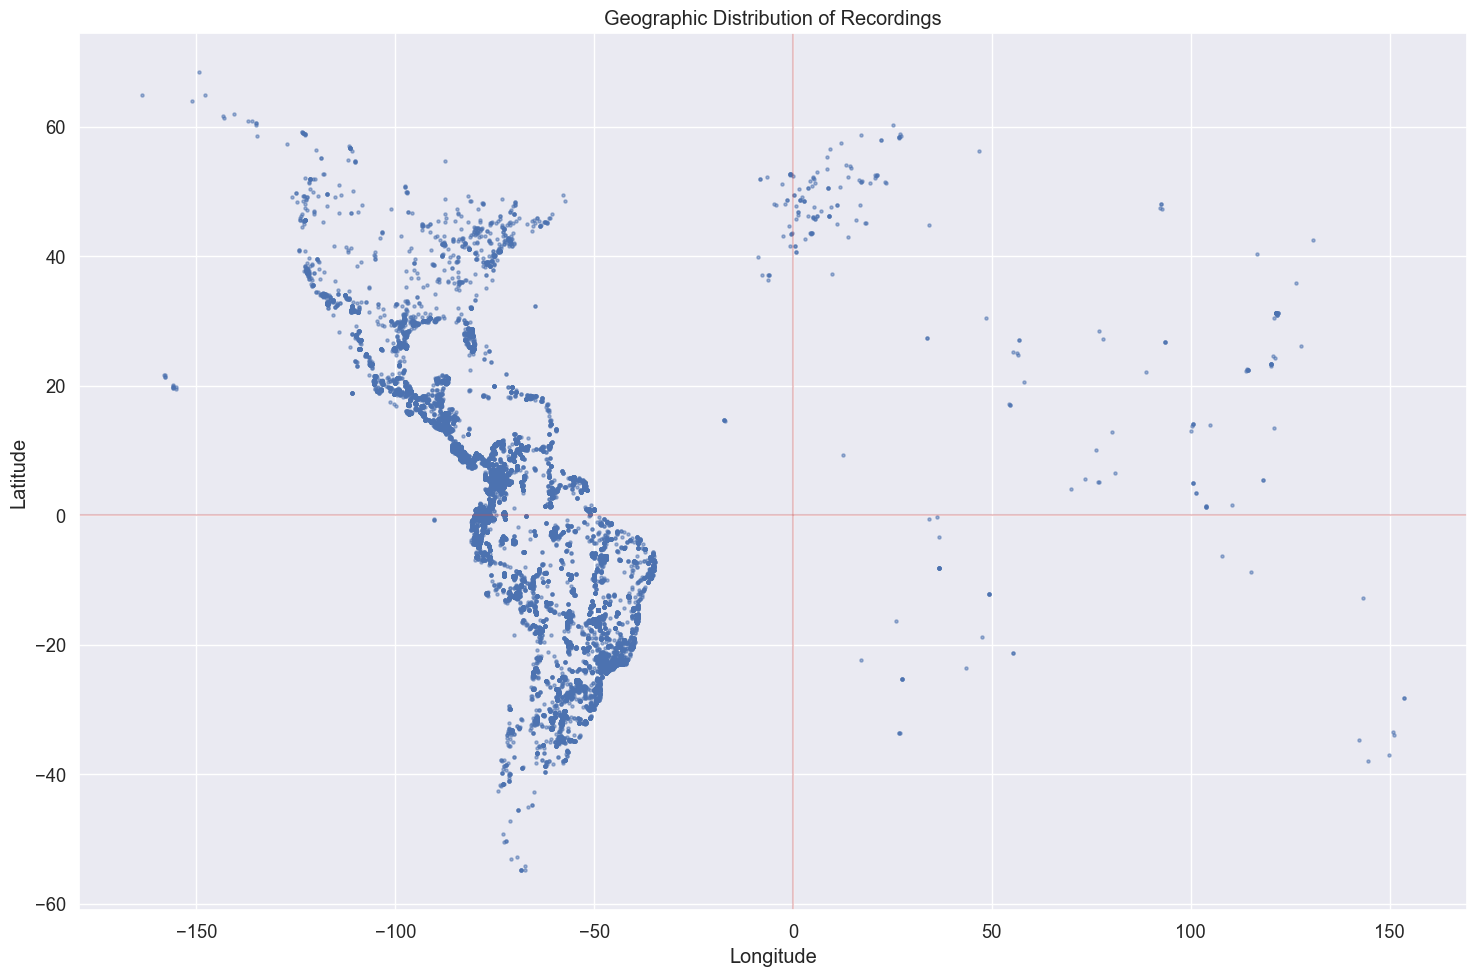

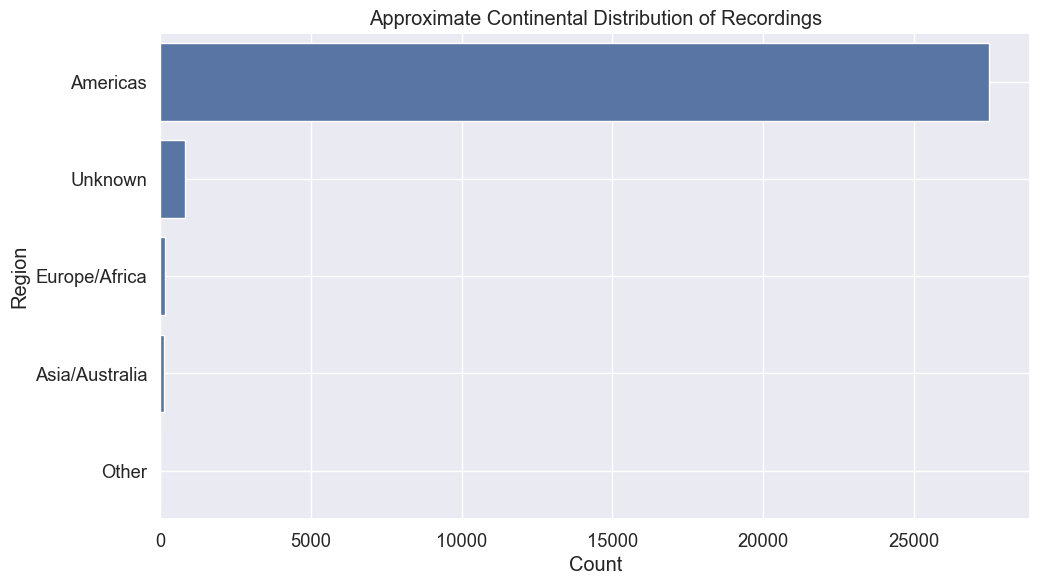

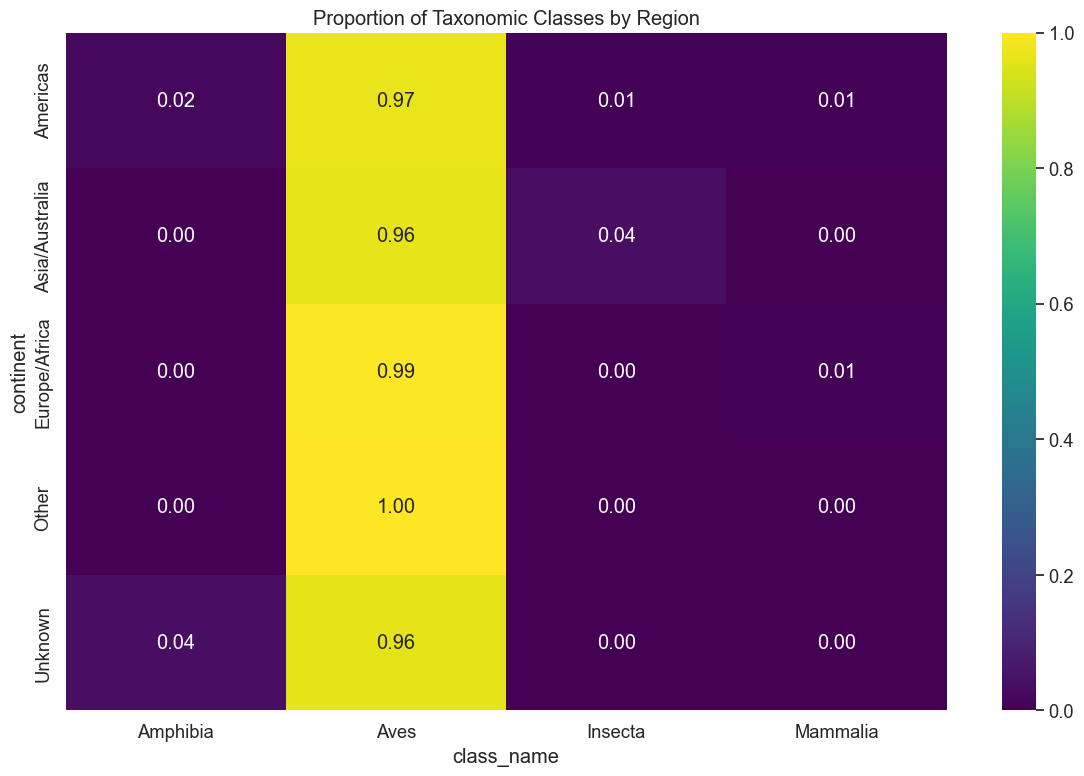

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training data (update with your file path)
train_df = pd.read_csv('train.csv')  # Update this path with the correct location of your train data

# Load the taxonomy data (update with your file path)
taxonomy_df = pd.read_csv('taxonomy.csv')  # Update this path with the correct location of your taxonomy data

# Merge train data with taxonomy for further analysis
train_with_taxonomy = pd.merge(train_df, taxonomy_df, on='primary_label', how='left')

# Check how many recordings have location data
has_location = ~(train_df['latitude'].isna() | train_df['longitude'].isna())
print(f"Recordings with location data: {has_location.sum()} ({has_location.sum()/len(train_df)*100:.2f}%)")

# Plot geographic distribution of recordings
plt.figure(figsize=(15, 10))
plt.scatter(
    train_df[has_location]['longitude'], 
    train_df[has_location]['latitude'],
    alpha=0.5,
    s=5
)
plt.title('Geographic Distribution of Recordings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # Equator
plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)  # Prime Meridian
plt.tight_layout()
plt.show()

# Function to assign continent based on latitude and longitude
def assign_continent(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return "Unknown"
    
    # Very rough approximation based on lat/lon
    if -30 <= lat <= 75 and -20 <= lon <= 40:
        return "Europe/Africa"
    elif -30 <= lat <= 75 and 40 <= lon <= 180:
        return "Asia/Australia"
    elif -60 <= lat <= 75 and -170 <= lon <= -20:
        return "Americas"
    else:
        return "Other"

# Add continent information to the merged dataset
train_with_taxonomy['continent'] = train_with_taxonomy.apply(lambda row: assign_continent(row['latitude'], row['longitude']), axis=1)

# Continental distribution plot
plt.figure(figsize=(10, 6))
sns.countplot(y=train_with_taxonomy['continent'])
plt.title('Approximate Continental Distribution of Recordings')
plt.xlabel('Count')
plt.ylabel('Region')
plt.grid(True)
plt.show()

# Analyze species by continent
if 'class_name' in train_with_taxonomy.columns:
    plt.figure(figsize=(12, 8))
    continent_class = pd.crosstab(train_with_taxonomy['continent'], train_with_taxonomy['class_name'])
    
    # Normalize by row (continent) to get proportion
    continent_class_norm = continent_class.div(continent_class.sum(axis=1), axis=0)
    
    # Heatmap to visualize the proportions
    sns.heatmap(continent_class_norm, cmap='viridis', annot=True, fmt='.2f')
    plt.title('Proportion of Taxonomic Classes by Region')
    plt.tight_layout()
    plt.show()


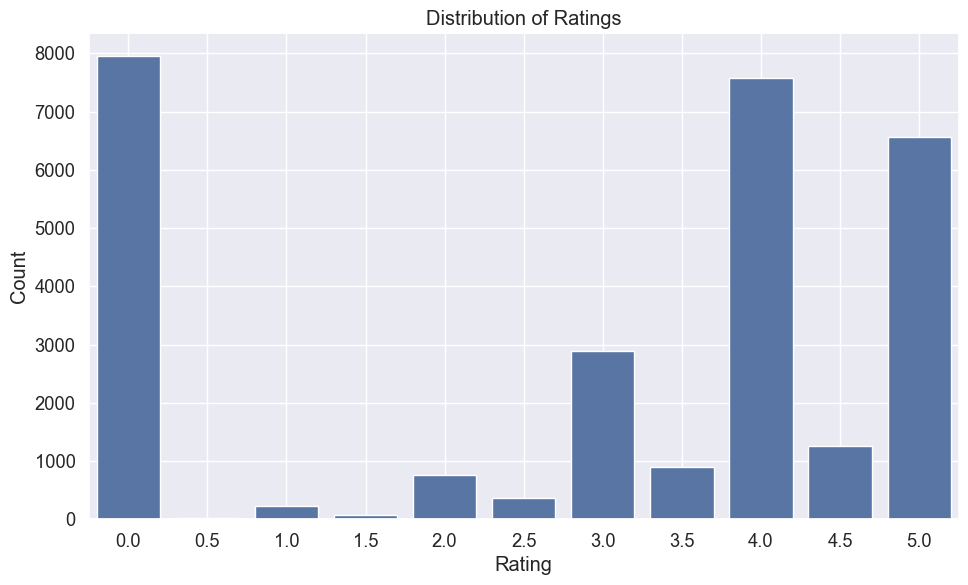

Average rating: 2.92
Median rating: 4.0


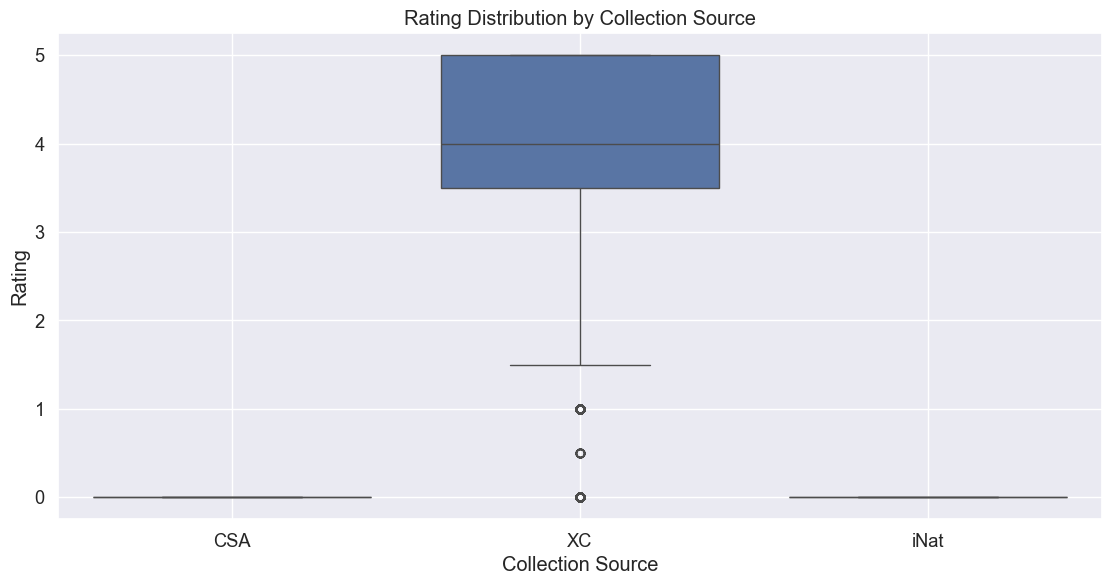

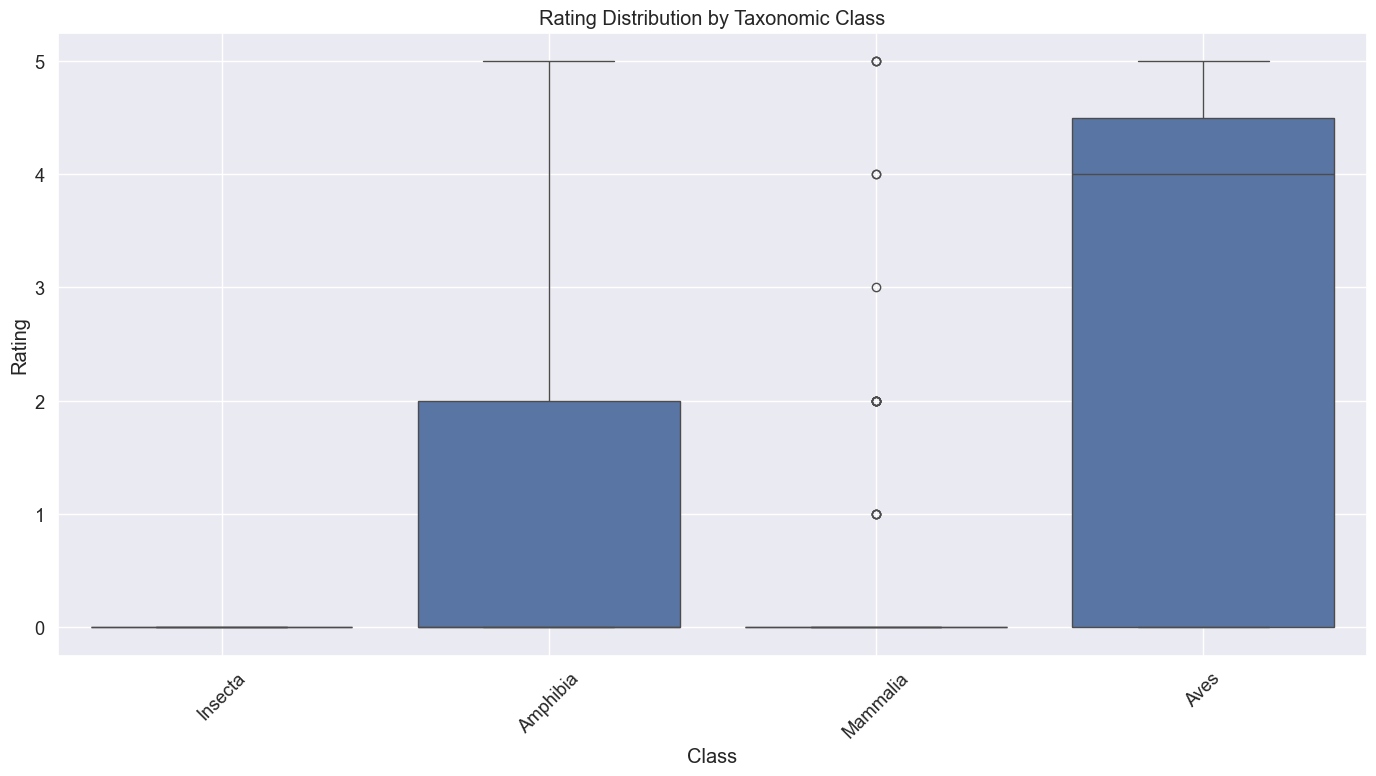

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=train_df['rating'])
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Print average and median rating
print(f"Average rating: {train_df['rating'].mean():.2f}")
print(f"Median rating: {train_df['rating'].median()}")

# Rating by collection source
plt.figure(figsize=(12, 6))
sns.boxplot(x='collection', y='rating', data=train_df)
plt.title('Rating Distribution by Collection Source')
plt.xlabel('Collection Source')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

# Rating by taxonomic class (if merged)
if 'class_name' in train_with_taxonomy.columns:
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='class_name', y='rating', data=train_with_taxonomy)
    plt.title('Rating Distribution by Taxonomic Class')
    plt.xlabel('Class')
    plt.ylabel('Rating')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


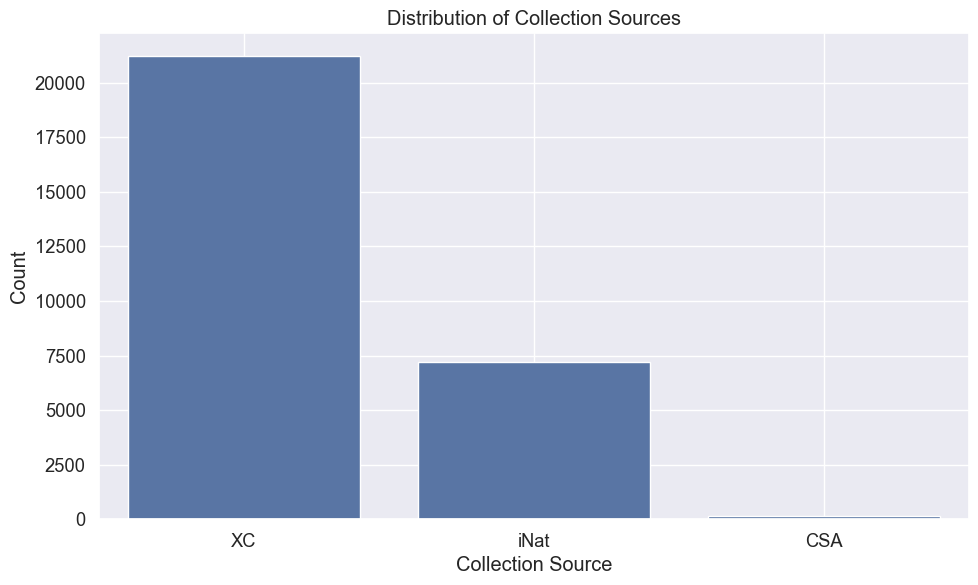

Collection source distribution:
XC: 21204 (74.23%)
iNat: 7198 (25.20%)
CSA: 162 (0.57%)

Top 10 species in XC:
roahaw: 500
grekis: 499
yeofly1: 466
trokin: 460
banana: 454
wbwwre1: 442
compau: 428
whtdov: 381
sobtyr1: 374
socfly1: 356

Top 10 species in iNat:
grekis: 491
compau: 380
trokin: 327
amekes: 277
soulap1: 216
compot1: 211
roahaw: 209
bbwduc: 204
whtdov: 191
socfly1: 187

Top 10 species in CSA:
52884: 33
50186: 30
48124: 20
715170: 17
1462737: 7
1564122: 6
1346504: 5
714022: 5
548639: 5
963335: 5


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collection source distribution
plt.figure(figsize=(10, 6))
collection_counts = train_df['collection'].value_counts()
sns.barplot(x=collection_counts.index, y=collection_counts.values)
plt.title('Distribution of Collection Sources')
plt.xlabel('Collection Source')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Print collection source distribution with counts and percentages
print(f"Collection source distribution:")
for source, count in collection_counts.items():
    print(f"{source}: {count} ({count/len(train_df)*100:.2f}%)")

# Species distribution by collection source
collection_species = pd.crosstab(train_df['collection'], train_df['primary_label'])
collection_species_norm = collection_species.div(collection_species.sum(axis=1), axis=0)

# Display top 10 species per collection source
for source in collection_counts.index:
    print(f"\nTop 10 species in {source}:")
    top_species = collection_species.loc[source].sort_values(ascending=False).head(10)
    for species, count in top_species.items():
        print(f"{species}: {count}")


Percentage of missing values per column:
latitude: 2.83%
longitude: 2.83%


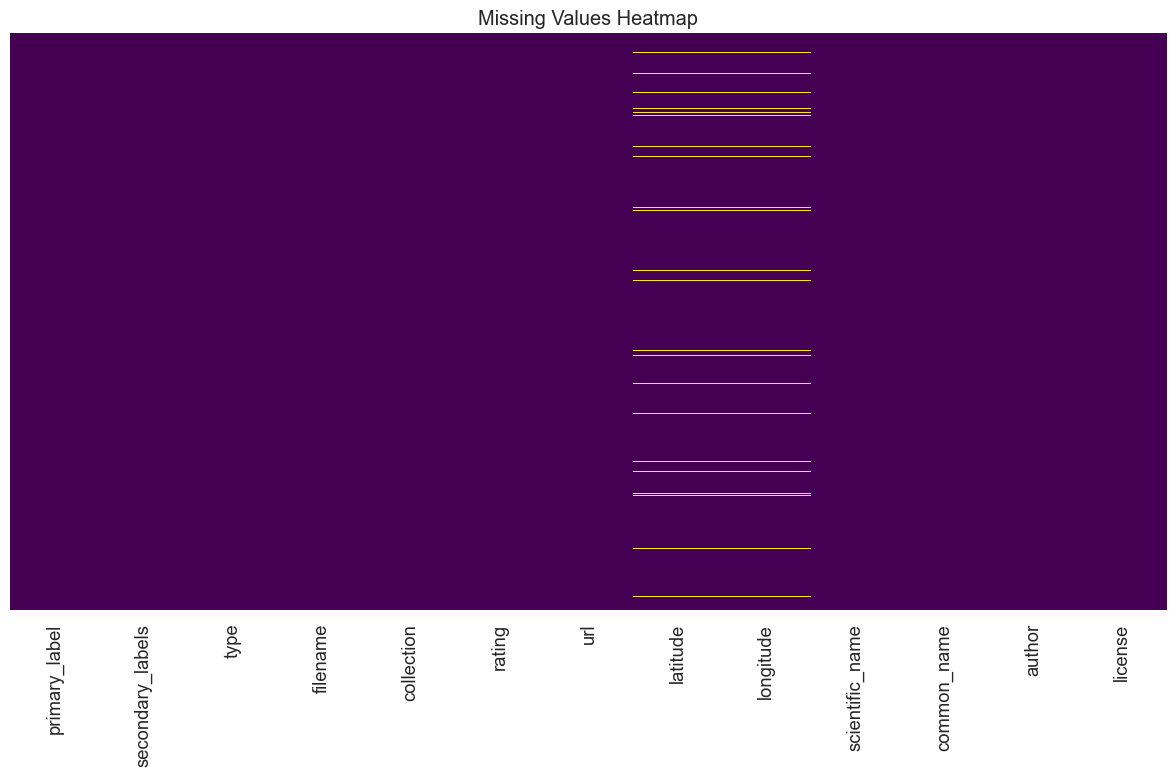

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate percentage of missing values per column
missing_percentage = (train_df.isnull().sum() / len(train_df) * 100).sort_values(ascending=False)
print("Percentage of missing values per column:")
for col, percentage in missing_percentage.items():
    if percentage > 0:
        print(f"{col}: {percentage:.2f}%")

# Visualize missing values
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

# Check for patterns in missing values
# For example, are missing ratings correlated with specific collections?
if train_df['rating'].isnull().sum() > 0:
    missing_ratings_by_collection = train_df[train_df['rating'].isnull()]['collection'].value_counts(normalize=True)
    total_by_collection = train_df['collection'].value_counts(normalize=True)
    
    print("\nProportion of missing ratings by collection source:")
    comparison = pd.DataFrame({
        'Missing Ratings %': missing_ratings_by_collection * 100,
        'Overall %': total_by_collection * 100
    })
    print(comparison)


In [66]:
def load_audio_file(file_path, sr=SAMPLE_RATE):
    """Load an audio file and return the signal."""
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Get list of audio files
train_audio_files = []
for root, _, files in os.walk(TRAIN_AUDIO_DIR):
    for file in files:
        if file.endswith('.ogg'):
            train_audio_files.append(os.path.join(root, file))

print(f"Total number of training audio files: {len(train_audio_files)}")

# Sample a few random files for analysis
random.seed(SEED)
sample_audio_files = random.sample(train_audio_files, min(5, len(train_audio_files)))

# Load sample files
sample_audios = []
for file_path in sample_audio_files:
    audio = load_audio_file(file_path)
    if audio is not None:
        filename = os.path.basename(file_path)
        label = filename.split('_')[0]  # Assuming filename format starts with label
        sample_audios.append({
            'path': file_path,
            'audio': audio,
            'duration': len(audio) / SAMPLE_RATE,
            'filename': filename,
            'label': label
        })

print(f"Loaded {len(sample_audios)} sample audio files")

Total number of training audio files: 28564
Loaded 5 sample audio files


Calculating durations for 500 files...


100%|██████████| 500/500 [00:11<00:00, 41.85it/s]


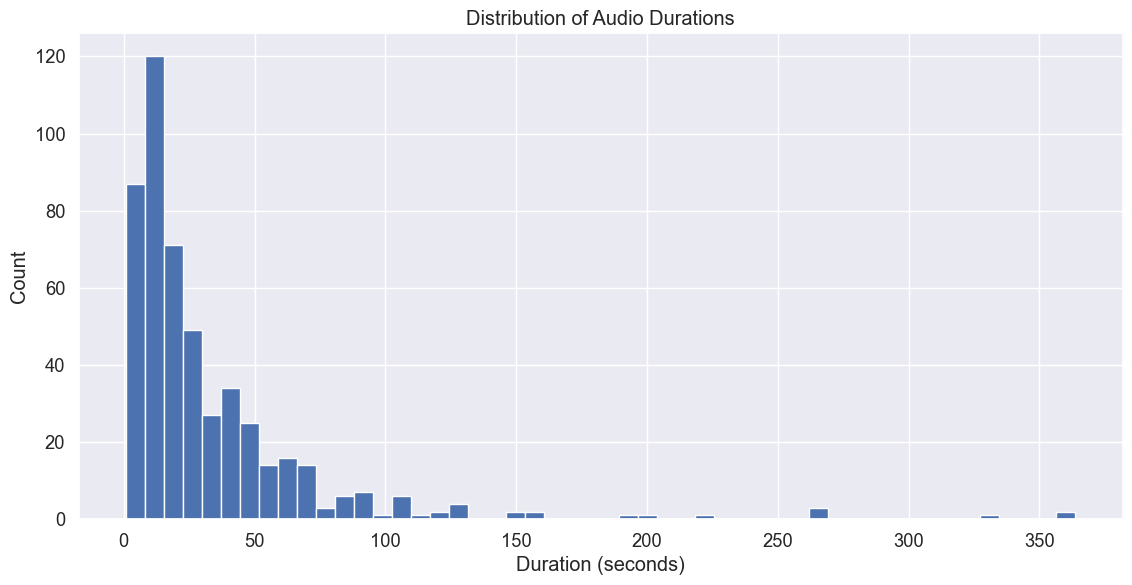

Duration statistics:
Mean duration: 33.44 seconds
Median duration: 20.14 seconds
Min duration: 0.83 seconds
Max duration: 363.62 seconds
Very short recordings (<1s): 1 (0.20%)
Long recordings (>60s): 71 (14.20%)


In [68]:
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to get audio duration
def get_audio_duration(file_path, sr=SAMPLE_RATE):
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        return len(audio) / sr  # Return duration in seconds
    except Exception as e:
        return None  # If loading fails, return None

# Sample audio files for duration analysis (this can be slow, so we'll sample)
duration_sample_size = min(500, len(train_audio_files))  # Limit to 500 samples or total number of files
duration_sample_files = random.sample(train_audio_files, duration_sample_size)

# Get durations
print(f"Calculating durations for {duration_sample_size} files...")
durations = []
for file_path in tqdm(duration_sample_files):
    duration = get_audio_duration(file_path)
    if duration is not None:
        durations.append(duration)

# Plot duration distribution
plt.figure(figsize=(12, 6))
plt.hist(durations, bins=50)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Duration statistics
print(f"Duration statistics:")
print(f"Mean duration: {np.mean(durations):.2f} seconds")
print(f"Median duration: {np.median(durations):.2f} seconds")
print(f"Min duration: {np.min(durations):.2f} seconds")
print(f"Max duration: {np.max(durations):.2f} seconds")

# Check for very short recordings (< 1s)
short_recordings = [d for d in durations if d < 1]
print(f"Very short recordings (<1s): {len(short_recordings)} ({len(short_recordings)/len(durations)*100:.2f}%)")

# Check for long recordings (> 60s)
long_recordings = [d for d in durations if d > 60]
print(f"Long recordings (>60s): {len(long_recordings)} ({len(long_recordings)/len(durations)*100:.2f}%)")


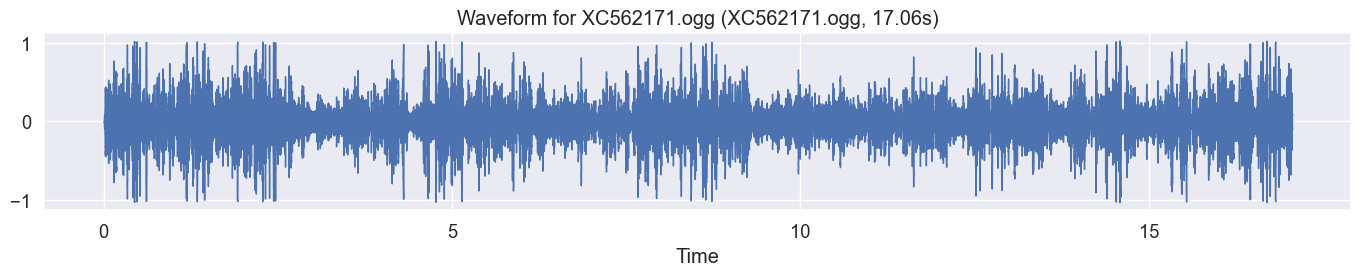

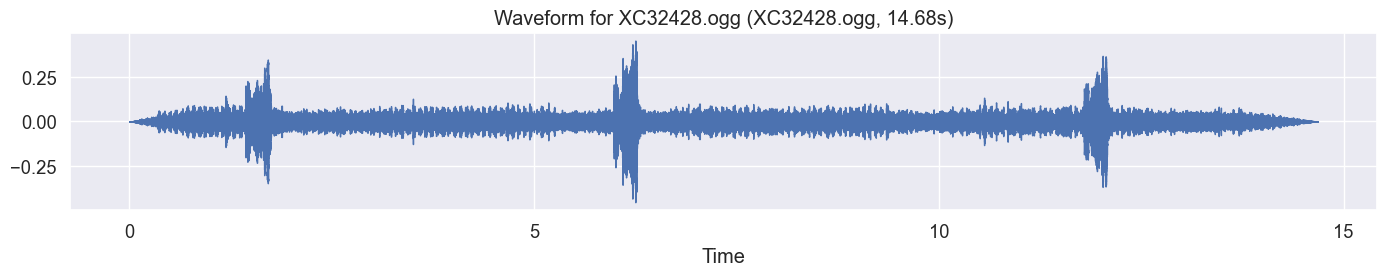

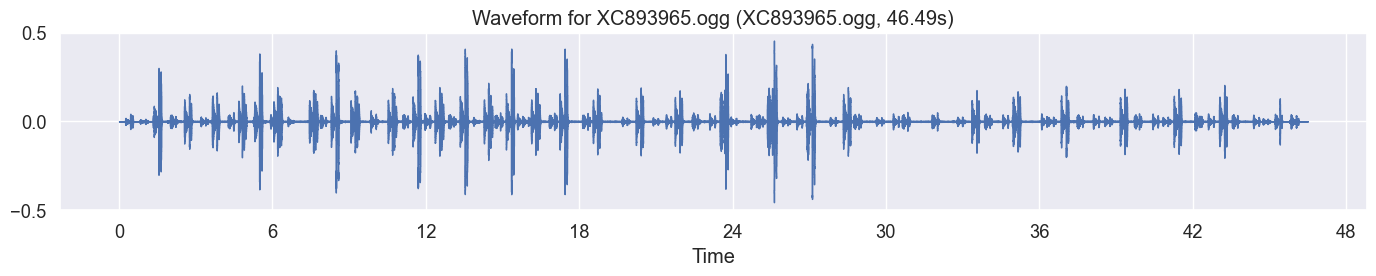

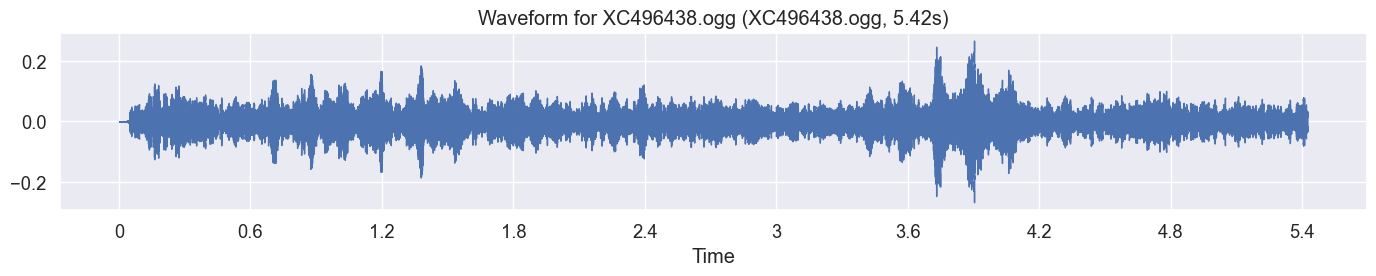

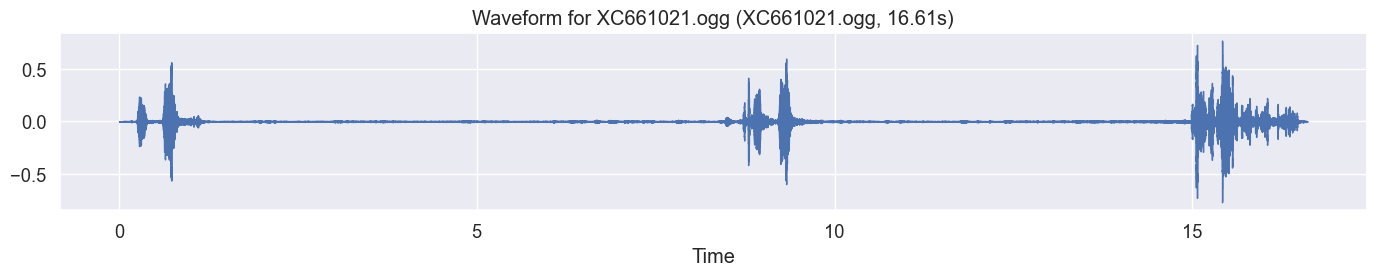

In [69]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio as ipd

# Assuming `sample_audios` is a list of dictionaries containing sample audio data
# sample_audios = [{'audio': audio_data, 'filename': 'file_path', 'label': 'species_name', 'duration': duration}]

# Plot waveforms for sample files
for i, sample in enumerate(sample_audios):
    plt.figure(figsize=(14, 3))
    librosa.display.waveshow(sample['audio'], sr=SAMPLE_RATE)
    plt.title(f"Waveform for {sample['filename']} ({sample['label']}, {sample['duration']:.2f}s)")
    plt.tight_layout()
    plt.show()
    
    # Play the audio (uncomment in notebook environment)
    # display(ipd.Audio(sample['audio'], rate=SAMPLE_RATE))


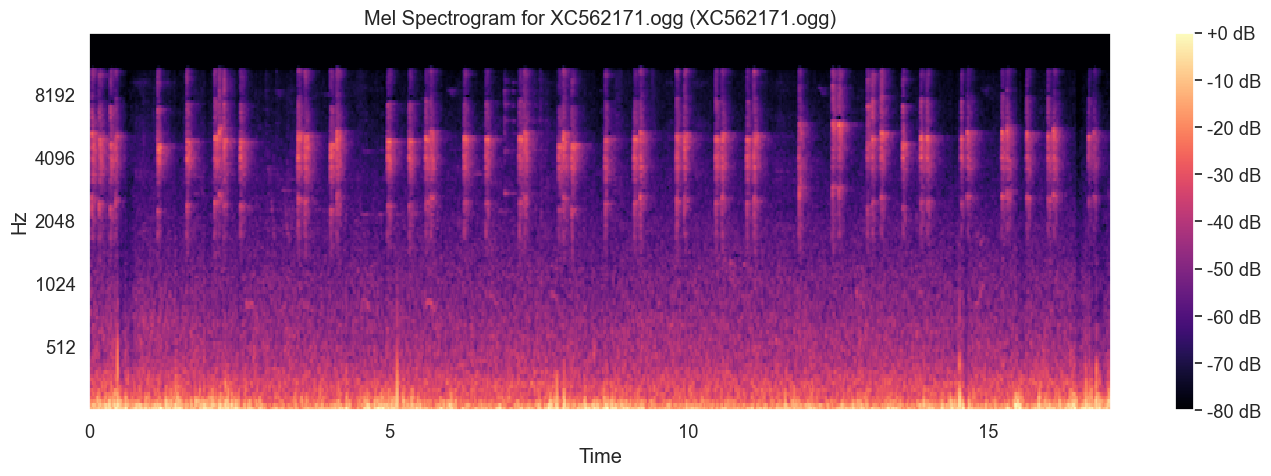

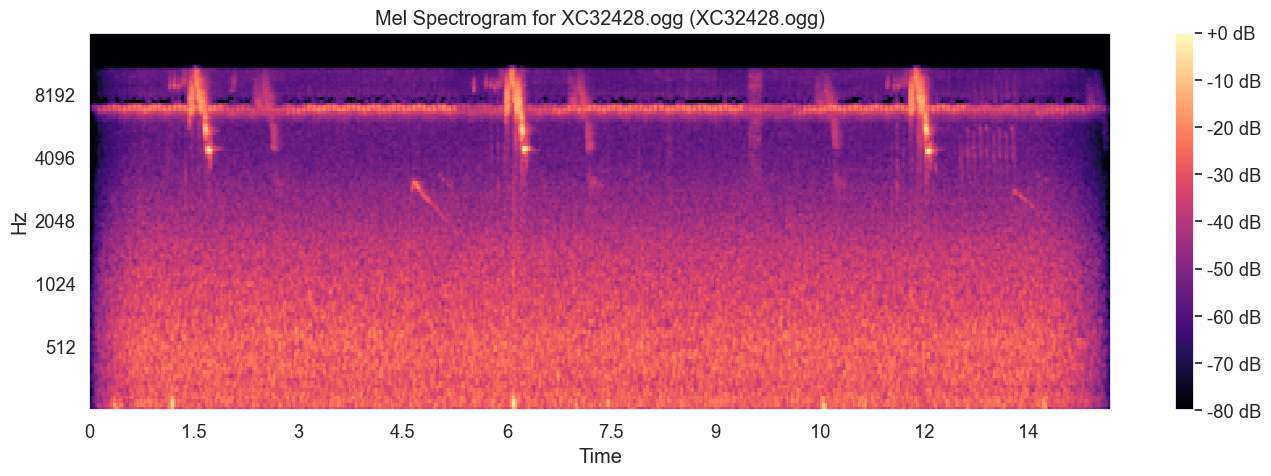

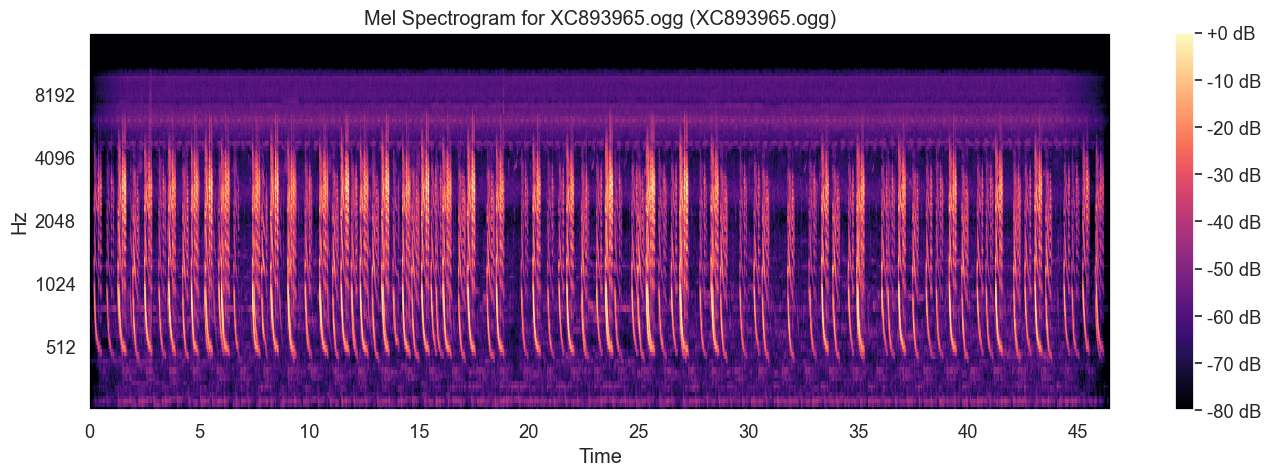

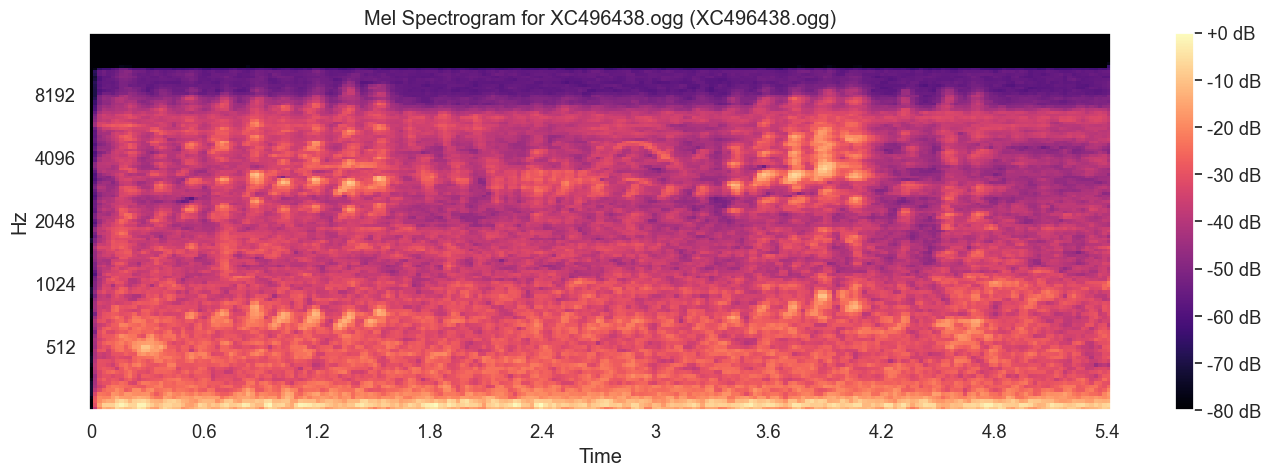

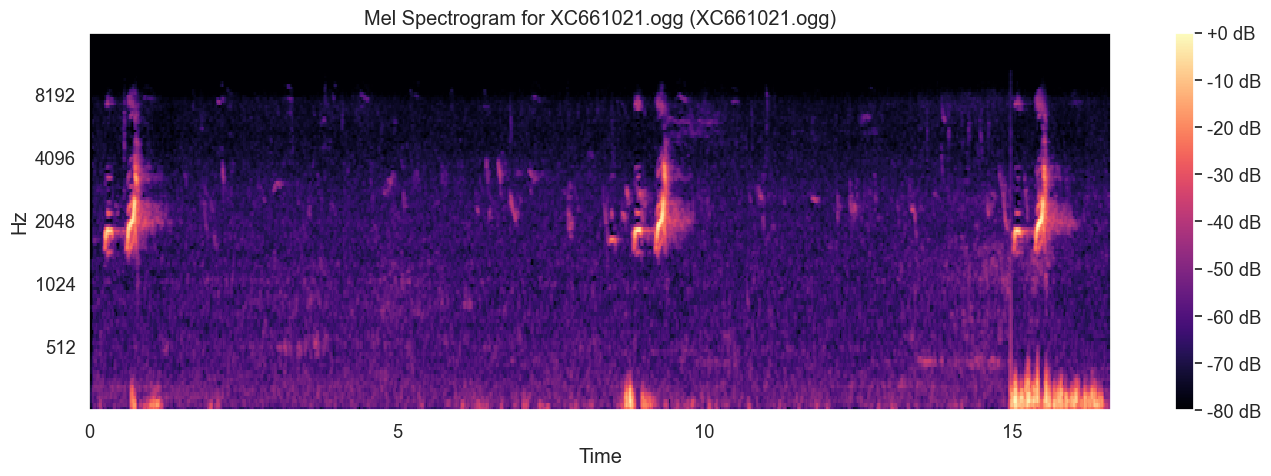

In [72]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Function to create mel spectrogram
def create_mel_spectrogram(audio, sr=SAMPLE_RATE, n_mels=128, fmin=20, fmax=16000):
    mel_spec = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr, 
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax
    )
    # Convert to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Create and display spectrograms for each sample in sample_audios
for i, sample in enumerate(sample_audios):
    mel_spec = create_mel_spectrogram(sample['audio'])
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(
        mel_spec, 
        sr=SAMPLE_RATE, 
        x_axis='time', 
        y_axis='mel', 
        fmin=20,
        fmax=16000
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram for {sample['filename']} ({sample['label']})")
    plt.tight_layout()
    plt.show()


In [74]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Function to estimate Signal-to-Noise Ratio (SNR)
def estimate_snr(audio):
    # Simple SNR estimation
    signal_power = np.mean(audio**2)
    noise_power = np.var(audio)
    if noise_power == 0:
        return float('inf')  # Infinite SNR if no noise
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to load audio (replace with your actual function to load audio)
def load_audio_file(file_path, sr=SAMPLE_RATE):
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        return audio
    except Exception as e:
        return None

# Calculate SNR for sample files
for sample in sample_audios:
    snr = estimate_snr(sample['audio'])
    print(f"Estimated SNR for {sample['filename']}: {snr:.2f} dB")

# Find recordings with different ratings
if len(train_df) > 0:
    # Get files with different ratings
    rating_examples = {}
    for rating in sorted(train_df['rating'].unique()):
        if pd.isna(rating):
            continue
        examples = train_df[train_df['rating'] == rating].head(2)
        for _, row in examples.iterrows():
            file_path = os.path.join(TRAIN_AUDIO_DIR, row['primary_label'], row['filename'])
            if os.path.exists(file_path):
                audio = load_audio_file(file_path)
                if audio is not None:
                    if rating not in rating_examples:
                        rating_examples[rating] = []
                    rating_examples[rating].append({
                        'path': file_path,
                        'audio': audio,
                        'duration': len(audio) / SAMPLE_RATE,
                        'filename': row['filename'],
                        'label': row['primary_label']
                    })
    
    # Plot waveforms and spectrograms for different ratings
    for rating, examples in rating_examples.items():
        for example in examples:
            # Plot waveform
            plt.figure(figsize=(14, 3))
            librosa.display.waveshow(example['audio'], sr=SAMPLE_RATE)
            plt.title(f"Waveform for Rating {rating}: {example['filename']} ({example['label']})")
            plt.tight_layout()
            plt.show()
            
            # Plot Mel Spectrogram
            mel_spec = create_mel_spectrogram(example['audio'])
            plt.figure(figsize=(14, 5))
            librosa.display.specshow(
                mel_spec, 
                sr=SAMPLE_RATE, 
                x_axis='time', 
                y_axis='mel', 
                fmin=20,
                fmax=16000
            )
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Mel Spectrogram for Rating {rating}: {example['filename']} ({example['label']})")
            plt.tight_layout()
            plt.show()


Estimated SNR for XC562171.ogg: 0.00 dB
Estimated SNR for XC32428.ogg: 0.00 dB
Estimated SNR for XC893965.ogg: 0.00 dB
Estimated SNR for XC496438.ogg: 0.00 dB
Estimated SNR for XC661021.ogg: 0.00 dB


In [76]:
import os
import random

# Define the path to your soundscape files directory
TRAIN_SOUNDSCAPE_DIR = 'train_soundscapes'  # Update this if the path differs

# Ensure the directory exists
if not os.path.exists(TRAIN_SOUNDSCAPE_DIR):
    print(f"Directory does not exist: {TRAIN_SOUNDSCAPE_DIR}")
else:
    print(f"Directory exists: {TRAIN_SOUNDSCAPE_DIR}")

# Collect soundscape files with .ogg extension
soundscape_files = []
for root, _, files in os.walk(TRAIN_SOUNDSCAPE_DIR):
    for file in files:
        if file.endswith('.ogg'):  # Ensure file format is correct
            soundscape_files.append(os.path.join(root, file))

# Output total number of soundscape files
print(f"Total number of training soundscape files: {len(soundscape_files)}")

# Sample soundscape files (up to 3)
sample_soundscape_files = random.sample(soundscape_files, min(3, len(soundscape_files)))
print(f"Loaded {len(sample_soundscape_files)} sample soundscape files")


Directory exists: train_soundscapes
Total number of training soundscape files: 9726
Loaded 3 sample soundscape files


Soundscape H8749_20230512_083500.ogg duration: 60.00 seconds
Soundscape H99_20230424_062000.ogg duration: 60.00 seconds
Soundscape H85_20230502_033000.ogg duration: 60.00 seconds


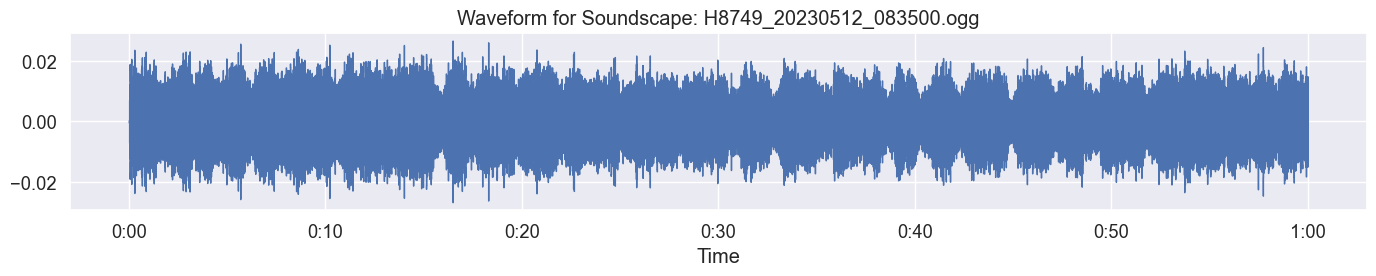

Number of 5-second chunks in H8749_20230512_083500.ogg: 12


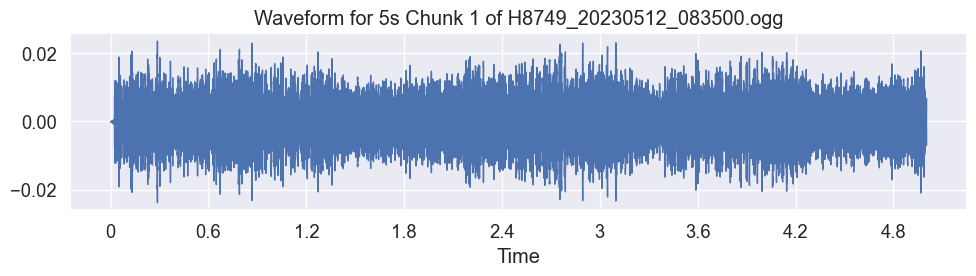

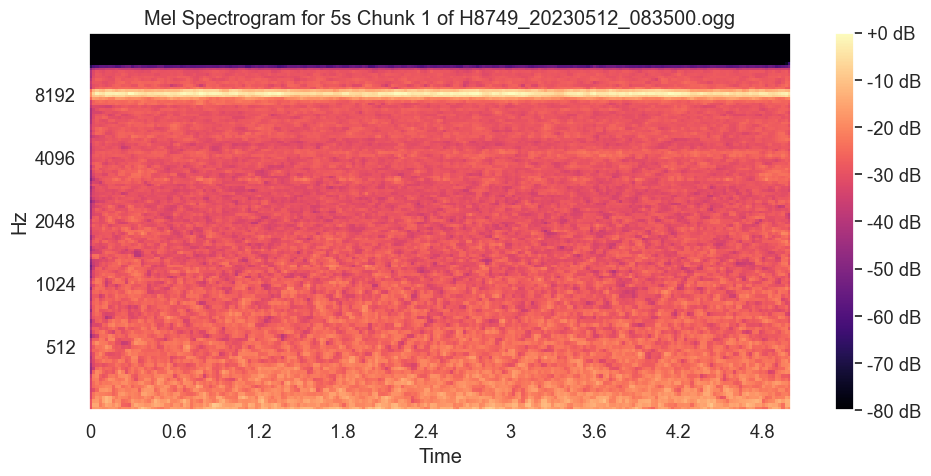

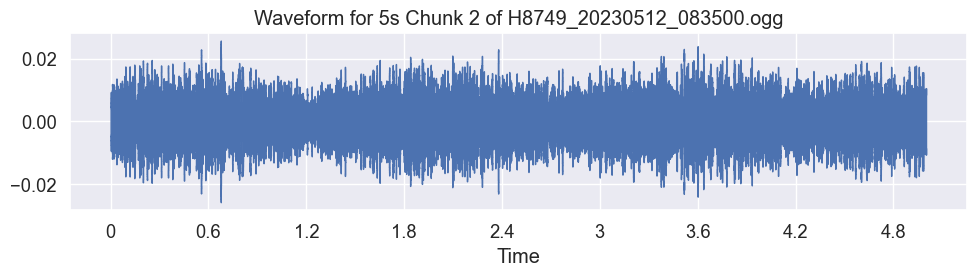

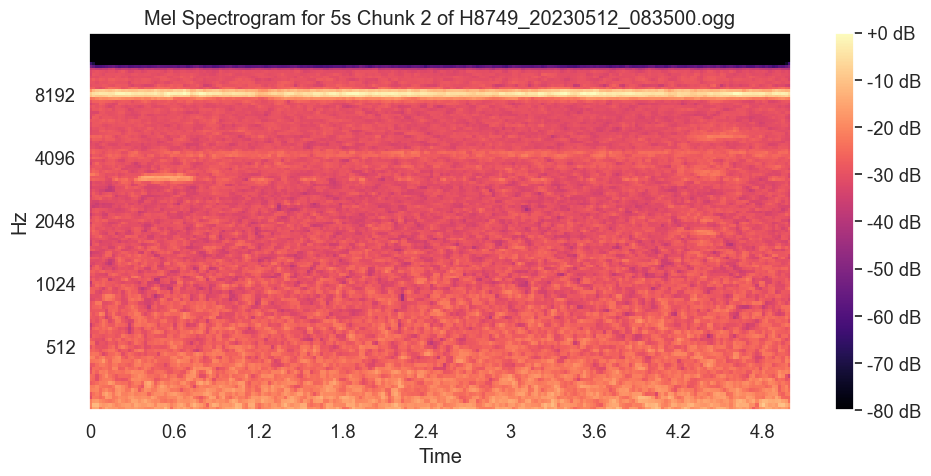

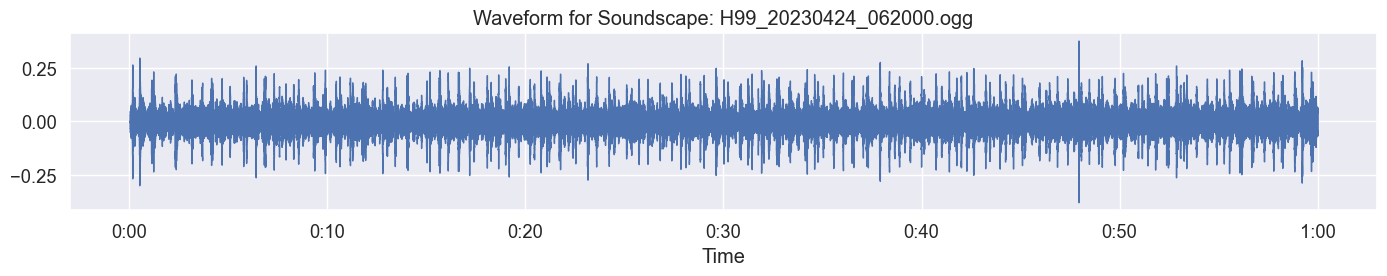

Number of 5-second chunks in H99_20230424_062000.ogg: 12


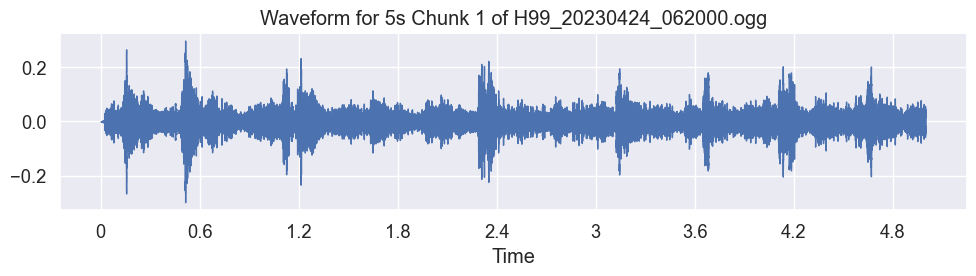

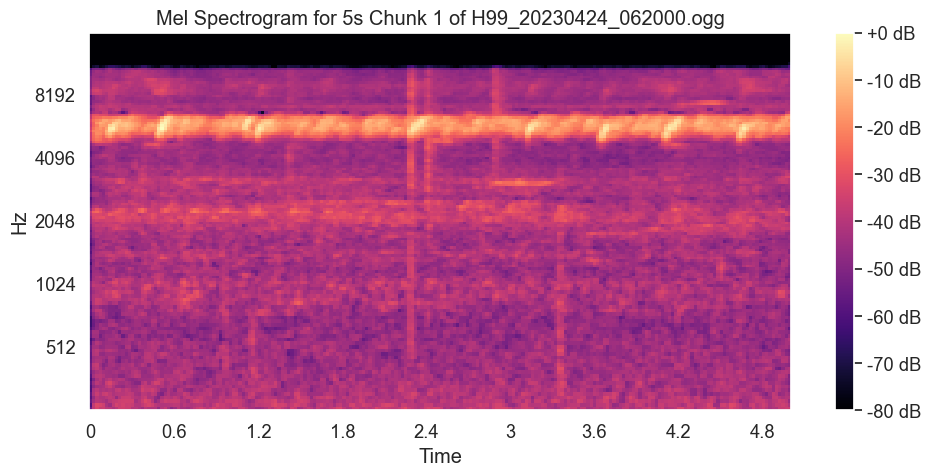

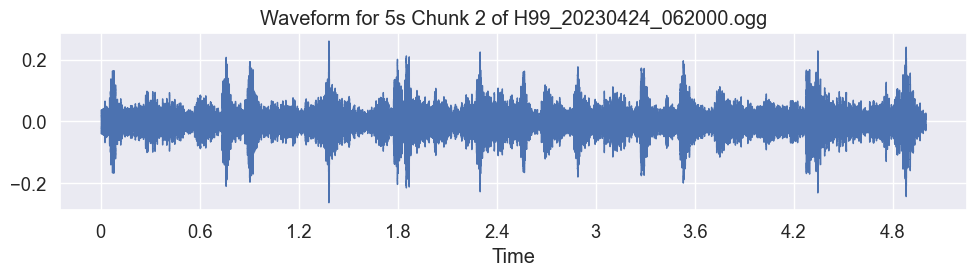

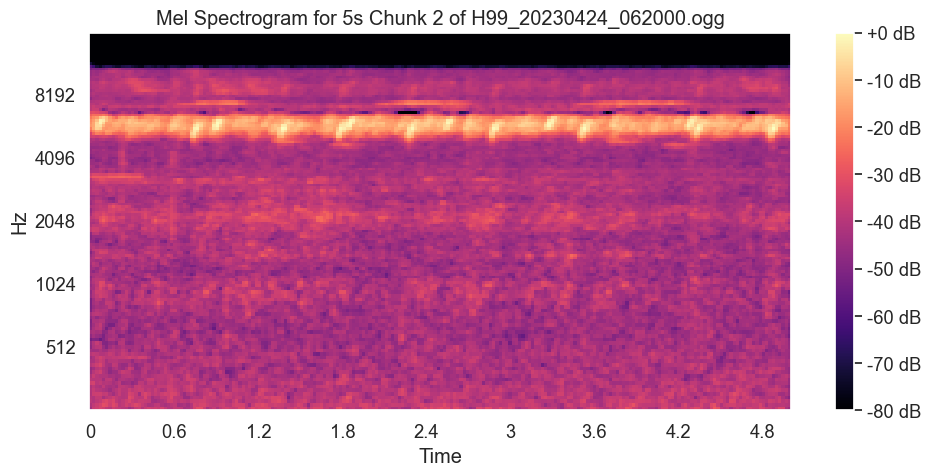

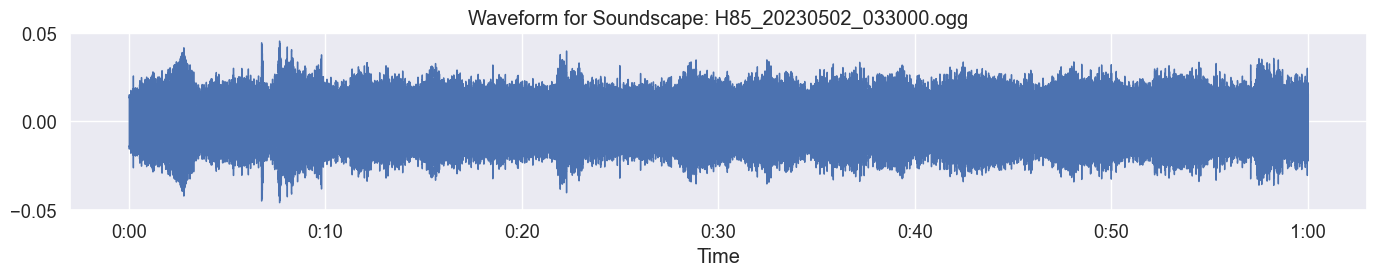

Number of 5-second chunks in H85_20230502_033000.ogg: 12


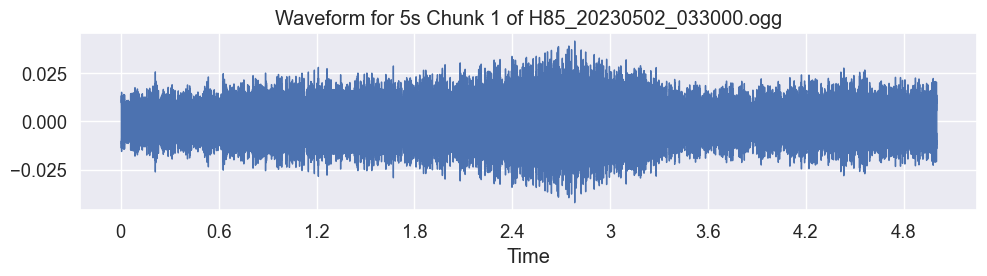

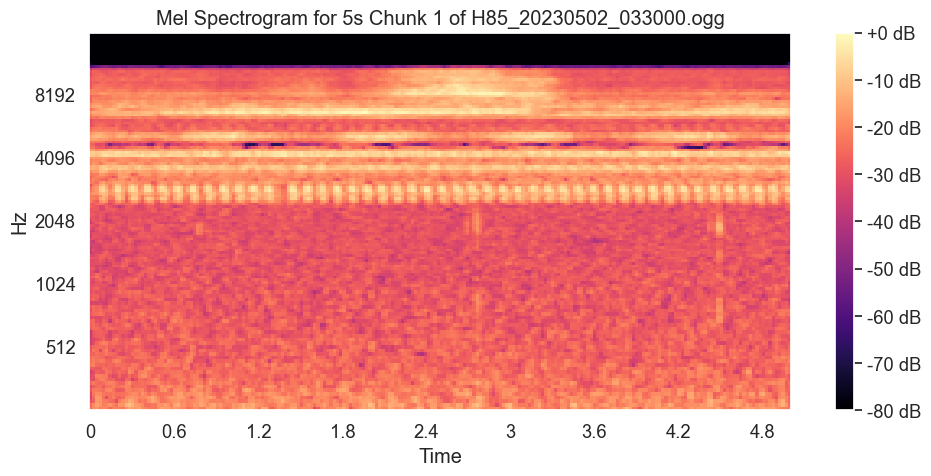

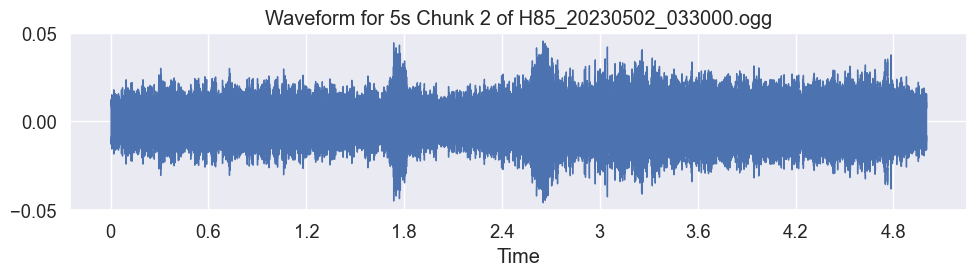

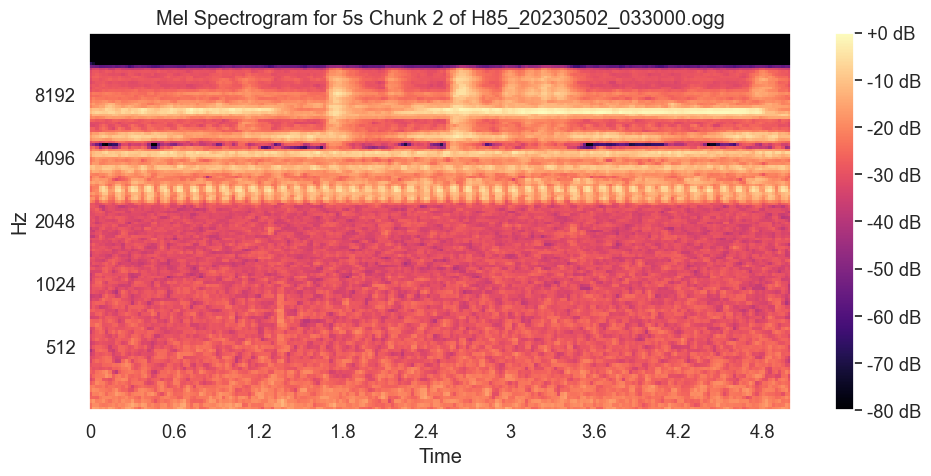

In [78]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio as ipd

# Assuming sample_soundscapes has the required data

# Analyze soundscape durations
for sample in sample_soundscapes:
    print(f"Soundscape {sample['filename']} duration: {sample['duration']:.2f} seconds")

# Plot waveforms and spectrograms for sample soundscapes
for sample in sample_soundscapes:
    # Plot full waveform of the soundscape
    plt.figure(figsize=(14, 3))
    librosa.display.waveshow(sample['audio'], sr=SAMPLE_RATE)
    plt.title(f"Waveform for Soundscape: {sample['filename']}")
    plt.tight_layout()
    plt.show()
    
    # Create and plot 5-second chunks to simulate test environment
    chunk_duration = 5  # seconds
    chunk_samples = chunk_duration * SAMPLE_RATE
    num_chunks = int(np.floor(len(sample['audio']) / chunk_samples))
    
    print(f"Number of 5-second chunks in {sample['filename']}: {num_chunks}")
    
    # Plot first two chunks as examples
    for i in range(min(2, num_chunks)):  # Plot up to 2 chunks
        chunk_start = i * chunk_samples
        chunk_end = (i + 1) * chunk_samples
        chunk = sample['audio'][chunk_start:chunk_end]
        
        # Plot waveform for the chunk
        plt.figure(figsize=(10, 3))
        librosa.display.waveshow(chunk, sr=SAMPLE_RATE)
        plt.title(f"Waveform for 5s Chunk {i+1} of {sample['filename']}")
        plt.tight_layout()
        plt.show()
        
        # Create and plot Mel Spectrogram for the chunk
        mel_spec = create_mel_spectrogram(chunk)
        plt.figure(figsize=(10, 5))
        librosa.display.specshow(
            mel_spec, 
            sr=SAMPLE_RATE, 
            x_axis='time', 
            y_axis='mel', 
            fmin=20,
            fmax=16000
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram for 5s Chunk {i+1} of {sample['filename']}")
        plt.tight_layout()
        plt.show()
        
        # Play the chunk (uncomment in notebook environment)
        # display(ipd.Audio(chunk, rate=SAMPLE_RATE))


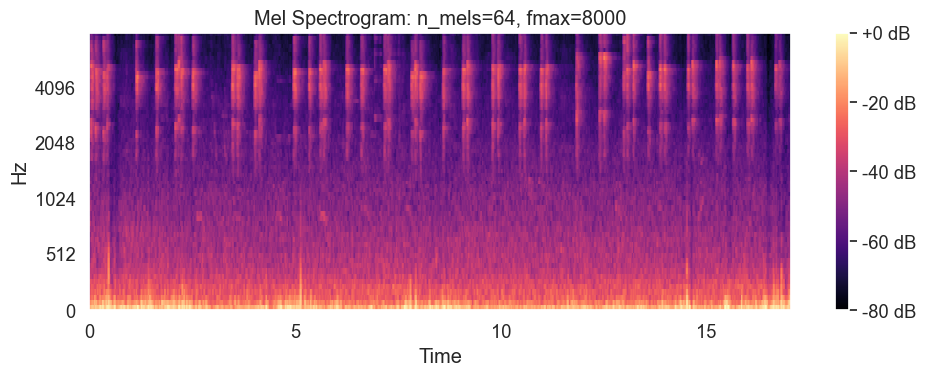

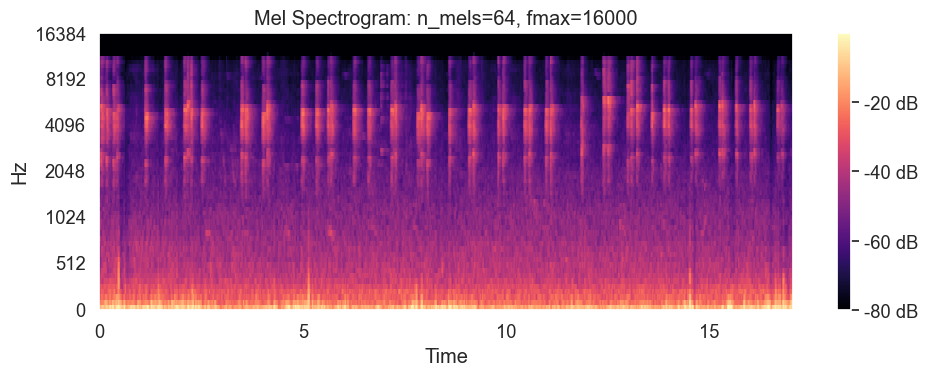

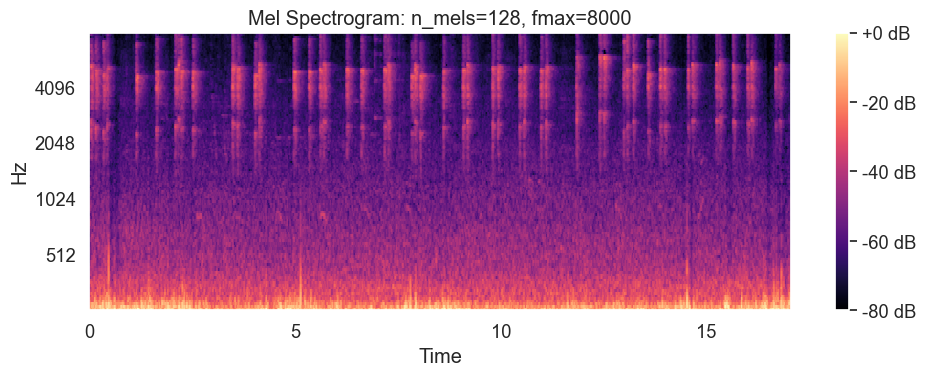

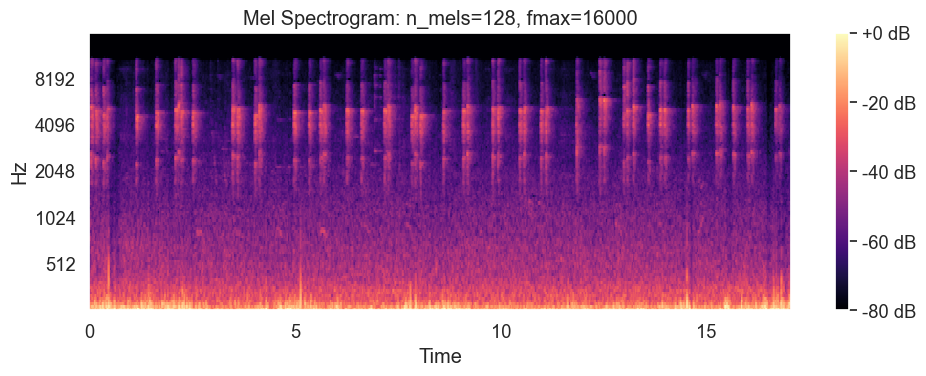

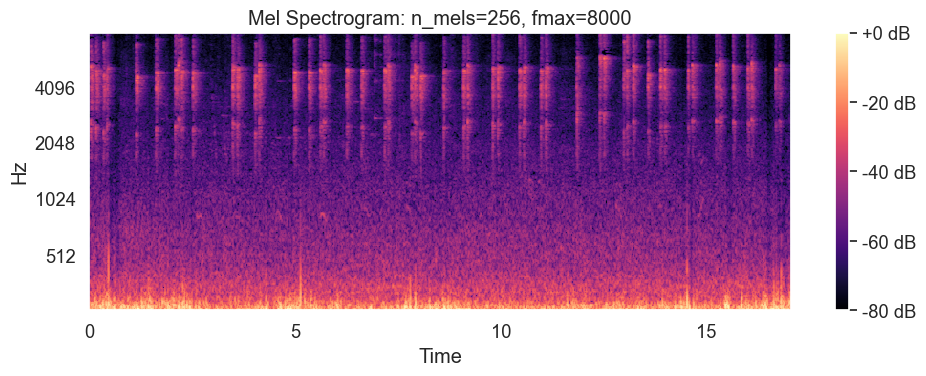

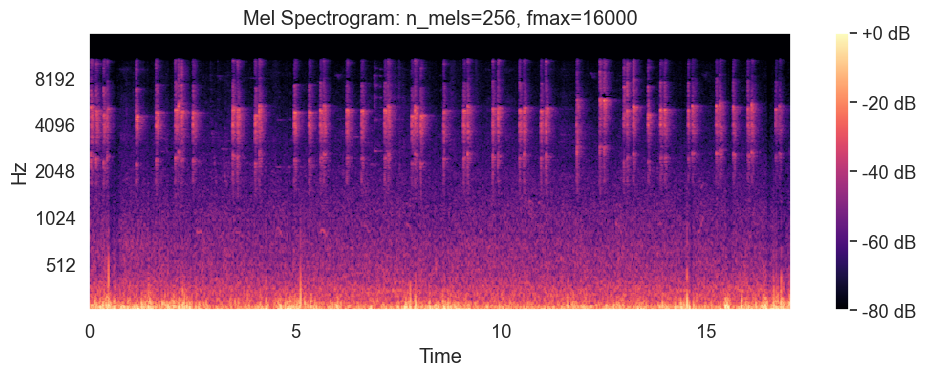

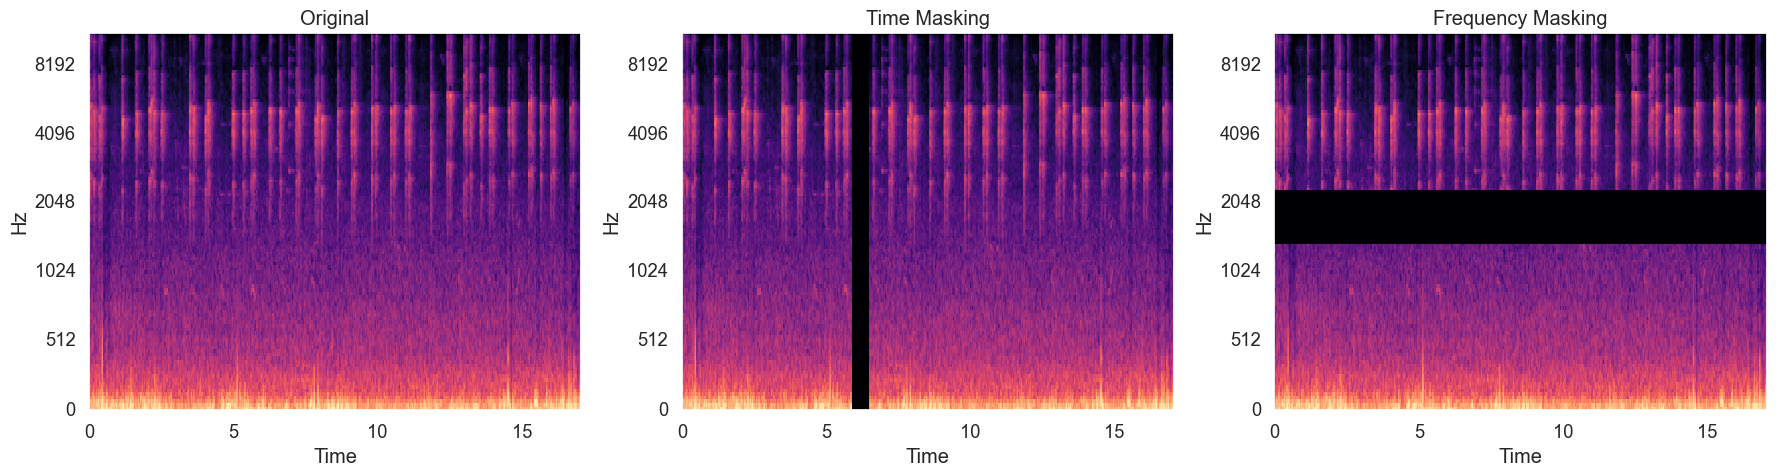

In [80]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Spectrogram parameter exploration
def explore_spectrogram_params(audio, sr=SAMPLE_RATE):
    """Explore different spectrogram parameters on a sample audio"""
    # Try different n_mels values
    n_mels_values = [64, 128, 256]
    fmax_values = [8000, 16000]
    
    for n_mels in n_mels_values:
        for fmax in fmax_values:
            plt.figure(figsize=(10, 4))
            mel_spec = librosa.feature.melspectrogram(
                y=audio, 
                sr=sr, 
                n_mels=n_mels,
                fmin=20,
                fmax=fmax
            )
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            librosa.display.specshow(
                mel_spec_db, 
                sr=sr, 
                x_axis='time', 
                y_axis='mel', 
                fmin=20,
                fmax=fmax
            )
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Mel Spectrogram: n_mels={n_mels}, fmax={fmax}")
            plt.tight_layout()
            plt.show()

# Run parameter exploration on a sample audio (choose one with clear vocalizations)
if len(sample_audios) > 0:
    # Find a sample with good vocalization (using the first one for simplicity)
    explore_spectrogram_params(sample_audios[0]['audio'])

# Try different time/frequency masks (SpecAugment-like)
def show_augmentation_examples(audio, sr=SAMPLE_RATE):
    """Show examples of different augmentation techniques"""
    # Original spectrogram
    mel_spec_orig = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec_db_orig = librosa.power_to_db(mel_spec_orig, ref=np.max)
    
    # Time masking
    mel_spec_time = mel_spec_orig.copy()
    mask_size = 25  # Adjust based on your spectrogram shape
    start = np.random.randint(0, mel_spec_time.shape[1] - mask_size)
    mel_spec_time[:, start:start+mask_size] = 0
    mel_spec_db_time = librosa.power_to_db(mel_spec_time, ref=np.max)
    
    # Frequency masking
    mel_spec_freq = mel_spec_orig.copy()
    mask_size = 20  # Adjust based on your spectrogram shape
    start = np.random.randint(0, mel_spec_freq.shape[0] - mask_size)
    mel_spec_freq[start:start+mask_size, :] = 0
    mel_spec_db_freq = librosa.power_to_db(mel_spec_freq, ref=np.max)
    
    # Plot all three
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    librosa.display.specshow(
        mel_spec_db_orig, 
        sr=sr, 
        x_axis='time', 
        y_axis='mel', 
        ax=axes[0]
    )
    axes[0].set_title("Original")
    
    librosa.display.specshow(
        mel_spec_db_time, 
        sr=sr, 
        x_axis='time', 
        y_axis='mel', 
        ax=axes[1]
    )
    axes[1].set_title("Time Masking")
    
    librosa.display.specshow(
        mel_spec_db_freq, 
        sr=sr, 
        x_axis='time', 
        y_axis='mel', 
        ax=axes[2]
    )
    axes[2].set_title("Frequency Masking")
    
    plt.tight_layout()
    plt.show()

# Show augmentation examples on a sample
if len(sample_audios) > 0:
    show_augmentation_examples(sample_audios[0]['audio'])


<Figure size 1500x1000 with 0 Axes>

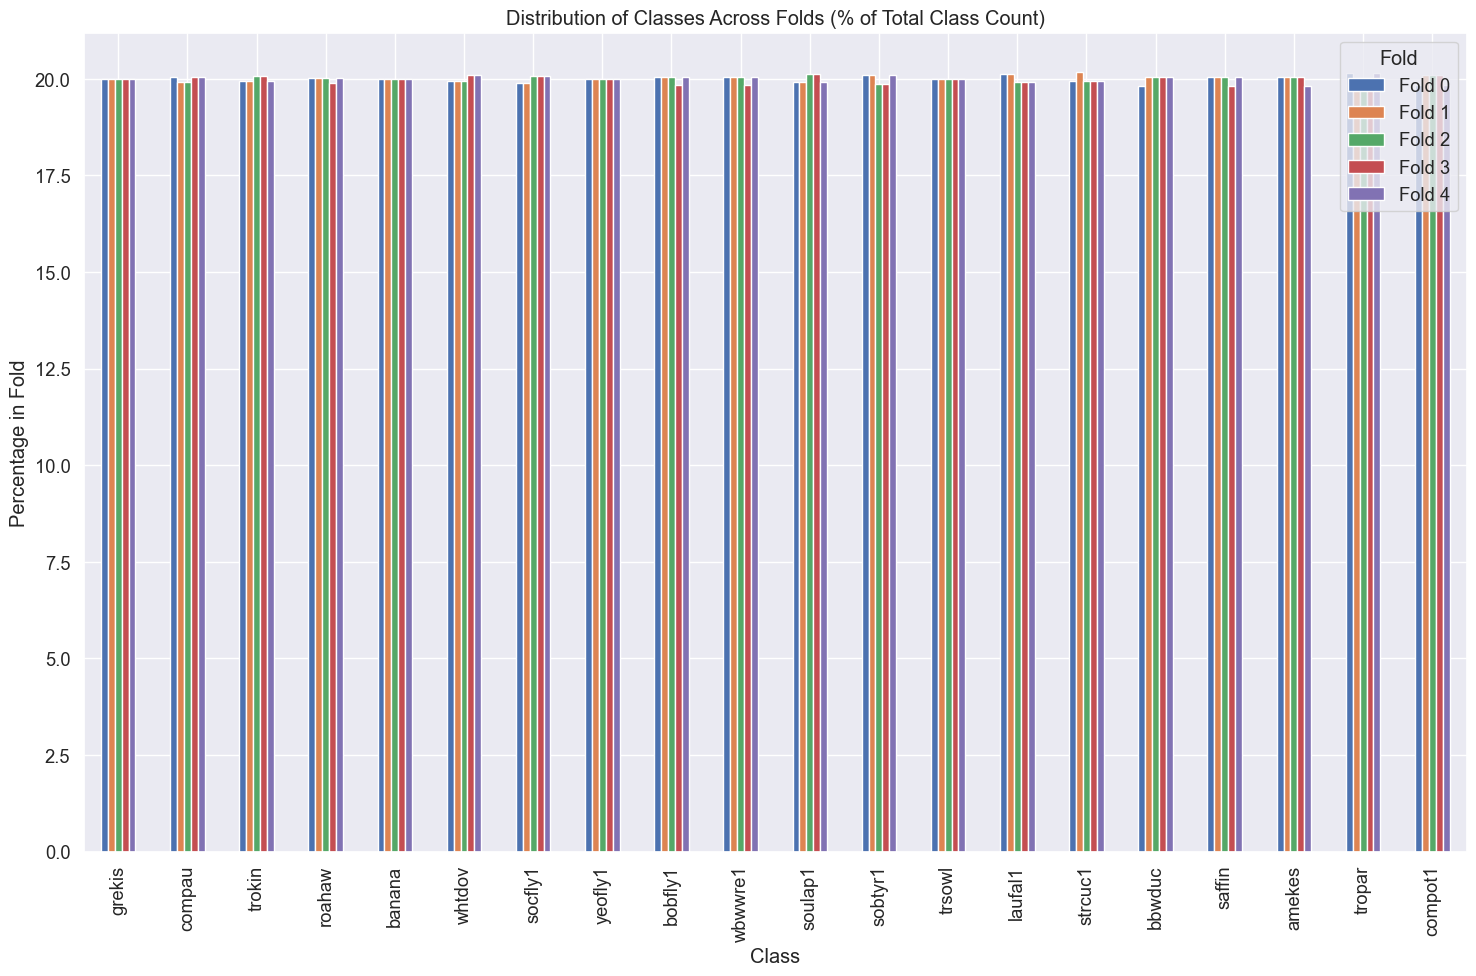

Class 1139490 has zero samples in fold 2
Class 1139490 has zero samples in fold 3
Class 1139490 has zero samples in fold 4
Class 1192948 has zero samples in fold 1
Class 1194042 has zero samples in fold 0
Class 1194042 has zero samples in fold 4
Class 134933 has zero samples in fold 4
Class 1462711 has zero samples in fold 2
Class 1462711 has zero samples in fold 3
Class 21038 has zero samples in fold 2


In [82]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Number of folds
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)

# Get counts for each class in the dataset
class_counts = train_df['primary_label'].value_counts()

# Add a 'fold' column to the train_df
train_df['fold'] = -1  # Initially set all folds to -1

# Apply Stratified K-Fold
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['primary_label'])):
    train_df.loc[val_idx, 'fold'] = fold_idx

# Check fold distribution (class counts in each fold)
fold_class_counts = []
for fold in range(n_folds):
    fold_counts = train_df[train_df['fold'] == fold]['primary_label'].value_counts()
    fold_class_counts.append(fold_counts)

# Plot fold distribution for the top 20 classes
top_20_classes = class_counts.index[:20]
fold_dist_df = pd.DataFrame(index=top_20_classes)

for fold in range(n_folds):
    fold_dist_df[f'Fold {fold}'] = fold_class_counts[fold].reindex(top_20_classes).fillna(0)

# Convert to percentage of the original class count
for cls in top_20_classes:
    fold_dist_df.loc[cls] = fold_dist_df.loc[cls] / class_counts[cls] * 100

# Plot the distribution of classes across folds (percentage of total class count)
plt.figure(figsize=(15, 10))
fold_dist_df.plot(kind='bar', figsize=(15, 10))
plt.title('Distribution of Classes Across Folds (% of Total Class Count)')
plt.xlabel('Class')
plt.ylabel('Percentage in Fold')
plt.legend(title='Fold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Check for classes with zero samples in any fold
zero_in_fold = []
for cls in train_df['primary_label'].unique():
    for fold in range(n_folds):
        if cls not in fold_class_counts[fold]:
            zero_in_fold.append((cls, fold))

# Display warning for any class-fold combinations with zero samples
if zero_in_fold:
    print(f"Warning: {len(zero_in_fold)} class-fold combinations have zero samples")
    for cls, fold in zero_in_fold[:10]:  # Show just the first 10
        print(f"Class {cls} has zero samples in fold {fold}")


In [84]:
import pandas as pd
import ast  # For safely parsing the string representations of lists

# Assuming train_df is already loaded and available

# Check if 'secondary_labels' exists in train_df
if 'secondary_labels' in train_df.columns:
    # Parse secondary labels (if not already parsed)
    def parse_secondary_labels(label_str):
        if pd.isna(label_str):
            return []
        try:
            return ast.literal_eval(label_str)  # Convert string representation of list to list
        except:
            return []

    # Apply the parsing function and create the 'parsed_secondary_labels' column
    train_df['parsed_secondary_labels'] = train_df['secondary_labels'].apply(parse_secondary_labels)
else:
    print("'secondary_labels' column not found in train_df.")

# Create the 'total_label_count' column which counts primary and secondary labels
train_df['total_label_count'] = train_df['parsed_secondary_labels'].apply(lambda x: len(x) + 1)  # +1 for primary label

# Now, calculate how many recordings have secondary labels
has_secondary = train_df['parsed_secondary_labels'].apply(lambda x: len(x) > 0)
print("=" * 50)
print("BirdCLEF+ 2025 EDA Summary")
print("=" * 50)

# Dataset size
print(f"\n1. Dataset Size:")
print(f"   - Training samples: {len(train_df)}")
print(f"   - Total classes: {N_CLASSES}")
print(f"   - Training audio files: {len(train_audio_files)}")
print(f"   - Unlabeled soundscapes: {len(soundscape_files)}")

# Class distribution
print(f"\n2. Class Distribution:")
print(f"   - Most common class: {primary_label_counts.index[0]} ({primary_label_counts.values[0]} samples)")
print(f"   - Least common class: {primary_label_counts.index[-1]} ({primary_label_counts.values[-1]} samples)")
print(f"   - Imbalance ratio: {primary_label_counts.values[0] / primary_label_counts.values[-1]:.2f}")
print(f"   - Classes with <10 samples: {len(rare_classes)}")

# Secondary labels
print(f"\n3. Secondary Labels:")
print(f"   - Recordings with secondary labels: {has_secondary.sum()} ({has_secondary.sum()/len(train_df)*100:.2f}%)")
print(f"   - Average labels per recording: {train_df['total_label_count'].mean():.2f}")

# Taxonomy
if 'class_name' in train_with_taxonomy.columns:
    print(f"\n4. Taxonomy:")
    for cls, count in class_counts.items():
        print(f"   - {cls}: {count} species")

# Audio characteristics
print(f"\n5. Audio Characteristics:")
print(f"   - Average duration: {np.mean(durations):.2f} seconds")
print(f"   - Duration range: {np.min(durations):.2f} - {np.max(durations):.2f} seconds")
print(f"   - Sample rate: {SAMPLE_RATE} Hz")

# Metadata completeness
print(f"\n6. Metadata Completeness:")
for col, percentage in missing_percentage.items():
    if percentage > 0:
        print(f"   - {col}: {percentage:.2f}% missing")

# Collection sources
print(f"\n7. Collection Sources:")
for source, count in collection_counts.items():
    print(f"   - {source}: {count} ({count/len(train_df)*100:.2f}%)")

# Geographic coverage
print(f"\n8. Geographic Coverage:")
has_location = ~(train_df['latitude'].isna() | train_df['longitude'].isna())
print(f"   - Recordings with location data: {has_location.sum()} ({has_location.sum()/len(train_df)*100:.2f}%)")

# Main challenges
print(f"\n9. Main Challenges:")
print(f"   - Class imbalance (potential solutions: class weighting, focal loss, data augmentation)")
print(f"   - Variable-length recordings (potential solutions: padding/chunking, attention mechanisms)")
print(f"   - Multi-label nature (requires appropriate loss function and evaluation metrics)")
print(f"   - Background noise (potential solutions: noise augmentation, robust feature extraction)")

# Validation strategy
print(f"\n10. Validation Strategy:")
print(f"   - {n_folds}-fold stratified cross-validation based on primary_label")
if zero_in_fold:
    print(f"   - Warning: {len(zero_in_fold)} class-fold combinations have zero samples")
    print(f"   - Consider using StratifiedGroupKFold or custom splitting for rare classes")

# Next steps
print("\n11. Next Steps:")
print("   - Implement audio loading and preprocessing pipeline")
print("   - Develop spectrogram generation with optimal parameters")
print("   - Create multi-label target encoding")
print("   - Implement data augmentation")
print("   - Design and train baseline model")


BirdCLEF+ 2025 EDA Summary

1. Dataset Size:
   - Training samples: 28564
   - Total classes: 206
   - Training audio files: 28564
   - Unlabeled soundscapes: 9726

2. Class Distribution:
   - Most common class: grekis (990 samples)
   - Least common class: 1139490 (2 samples)
   - Imbalance ratio: 495.00
   - Classes with <10 samples: 39

3. Secondary Labels:
   - Recordings with secondary labels: 28539 (99.91%)
   - Average labels per recording: 2.04

4. Taxonomy:
   - grekis: 990 species
   - compau: 808 species
   - trokin: 787 species
   - roahaw: 709 species
   - banana: 610 species
   - whtdov: 572 species
   - socfly1: 543 species
   - yeofly1: 525 species
   - bobfly1: 514 species
   - wbwwre1: 499 species
   - soulap1: 487 species
   - sobtyr1: 478 species
   - trsowl: 470 species
   - laufal1: 467 species
   - strcuc1: 431 species
   - bbwduc: 424 species
   - saffin: 419 species
   - amekes: 409 species
   - tropar: 397 species
   - compot1: 383 species
   - blbgra1: 380 sp